### Gap Junction Segmentation Model Training Pipeline

In [1]:
#Libraries
import torch
from torch import nn
from utilities import UpBlock, DownBlock, DoubleConv, GenDLoss, FocalLoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryRecall, BinaryPrecision, BinaryF1Score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
import cv2
from tqdm.notebook import tqdm #Change to tqdm.tqdm if not using Jupyter Notebook
import copy
import wandb
#Custom Libraries
from resize_image import resize_image

In [ ]:
#WandB Initialization
wandb.login(key="04e003d2c64e518f8033ab016c7a0036545c05f5")
wandb.init(project="gap-junction-segmentation", 
           entity="zhen_lab",
           name="unet_pooled_run_1",
           dir="/home/tommytang111/gap-junction-segmentation/wandb/unet_pooled_runs",
           reinit=True,
           config={
               "learning_rate": 0.001,
               "batch_size": 8,
               "epochs": 30,
               "image_size": (512, 512),
               "loss_function": "Generalized Dice Loss",
               "optimizer": "Adam",
               "scheduler": "ReduceLROnPlateau"
           }
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc
wandb: Currently logged in as: tommytang111 (zhen_lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


#### Set Reproducible Seeds

In [12]:
def seed_everything(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    
def worker_init_fn(worker_id):
    seed = 42 + worker_id
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seed_everything(42)

#### Define Augmentation Options

In [ ]:
# Custom augmentation
def get_custom_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(scale=(0.5,1.5), rotate=90, translate_percent=0.15, shear = (-45, 45), p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        A.Resize(512, 512),
        ToTensorV2()
    ])

# Light augmentation for gap junction segmentation
def get_light_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.GaussNoise(p=0.3),
        A.Blur(blur_limit=3, p=0.2),
        A.Normalize(mean=0.0, std=1.0),  # For grayscale
        ToTensorV2()
    ])

# Medium augmentation
def get_medium_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1, 
            scale_limit=0.2, 
            rotate_limit=15, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.5
        ),
        A.ElasticTransform(
            alpha=1, 
            sigma=50, 
            alpha_affine=50, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.3
        ),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.Blur(blur_limit=3, p=0.2),
        A.CLAHE(clip_limit=2.0, p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        ToTensorV2()
    ])
    
# Heavy augmentation
def get_heavy_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.15, 
            scale_limit=0.3, 
            rotate_limit=25, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.6
        ),
        A.ElasticTransform(
            alpha=1, 
            sigma=50, 
            alpha_affine=50, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            p=0.4
        ),
        A.GridDistortion(p=0.3),
        A.OpticalDistortion(p=0.3),
        A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),
        A.OneOf([
            A.Blur(blur_limit=3),
            A.GaussianBlur(blur_limit=3),
            A.MedianBlur(blur_limit=3),
        ], p=0.3),
        A.CLAHE(clip_limit=2.0, p=0.4),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.Normalize(mean=0.0, std=1.0),
        ToTensorV2()
    ])

#### Make Dataset Class

In [19]:
#Class can load any mask as long as the model corresponds to the mask type
class TrainingDataset(Dataset):
    def __init__(self, images, labels, masks=None, augmentation=None, data_size=(512, 512), train=True):
        self.image_paths = sorted([os.path.join(images, img) for img in os.listdir(images)])
        self.label_paths = sorted([os.path.join(labels, lbl) for lbl in os.listdir(labels)])
        self.mask_paths = sorted([os.path.join(masks, mask) for mask in os.listdir(masks)]) if masks else None
        self.augmentation = augmentation
        self.data_size = data_size
        self.train = train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        #Read image, label, and mask
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.label_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE) if self.mask_paths else None
        
        #Apply resizing with padding if image is not expected size and then convert back to ndarray
        if (image.shape[0] != self.data_size[0]) or (image.shape[1] != self.data_size[1]): 
            image = np.array(resize_image(image, self.data_size[0], self.data_size[1], (0,0,0)))
            label = np.array(resize_image(label, self.data_size[0], self.data_size[1], (0,0,0)))
            if mask is not None:
                mask = np.array(resize_image(mask, self.data_size[0], self.data_size[1], (0,0,0)))

        #Convert mask/label to binary for model classification
        label[label > 0] = 1
        if mask is not None:
            mask[mask > 0] = 1
        
        #Apply augmentation if provided
        if self.augmentation and self.train:
            if mask is not None:
                #Use mask in augmentation
                augmented = self.augmentation(image=image, mask=label, label=mask)
                image = augmented['image']
                label = augmented['mask']
                mask = augmented['label']
            else:
                #Without mask
                augmented = self.augmentation(image=image, mask=label)
                image = augmented['image']
                label = augmented['mask']

        #Add entity recognition clause later if needed
        
        # Convert to tensors if not already converted from augmentation
        if not torch.is_tensor(image):
            image = ToTensor()(image).float()
        if not torch.is_tensor(label):
            label = torch.from_numpy(label).long()
        if mask is not None and not torch.is_tensor(mask):
            mask = torch.from_numpy(mask).long()
        elif mask is None:
            mask = torch.zeros_like(label)

        return image, label, mask

#### Set Augmentation

In [20]:
#For training with augmentation
train_augmentation = get_custom_augmentation()  # Change to get_medium_augmentation() or get_heavy_augmentation() as needed

# For validation without augmentation
valid_augmentation = A.Compose([
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])

/tmp/ipykernel_6060/1873397690.py:6: UserWarning: Argument(s) 'rotate_limit' are not valid for transform Affine
  A.Affine(scale=(0.5,1.5), rotate_limit=90, translate_percent=0.15, p=1.0),
/tmp/ipykernel_6060/1873397690.py:10: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(512, 512, always_apply=True),


#### Initialize and Load Datasets

In [21]:
train = TrainingDataset(
    images="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs",
    labels="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts",
    augmentation=train_augmentation,
    train=True,
)

valid = TrainingDataset(
    images="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/imgs",
    labels="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/gts",
    augmentation=valid_augmentation,
    train=False
)

train_dataloader = DataLoader(train, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

#### Initialize model and send to gpu

In [22]:
class UNet(nn.Module):
    """UNet Architecture"""
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose', three=False, attend=False, residual=False, scale=False, spatial=False, dropout=0, classes=2):
        """Initialize the UNet model"""
        super(UNet, self).__init__()
        self.three = three
        self.up_sample_mode = up_sample_mode
        self.dropout=dropout

        # Downsampling Path
        self.down_conv1 = DownBlock(1, 64, three=three, spatial=False, residual=residual) # 3 input channels --> 64 output channels
        self.down_conv2 = DownBlock(64, 128, three=three, spatial=spatial, dropout=self.dropout, residual=residual) # 64 input channels --> 128 output channels
        self.down_conv3 = DownBlock(128, 256, spatial=spatial, dropout=self.dropout, residual=residual) # 128 input channels --> 256 output channels
        self.down_conv4 = DownBlock(256, 512, spatial=spatial, dropout=self.dropout, residual=residual) # 256 input channels --> 512 output channels
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024,spatial=spatial, dropout=self.dropout, residual=residual)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode, dropout=self.dropout, residual=residual) # 512 + 1024 input channels --> 512 output channels
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode, dropout=self.dropout, residual=residual)
        self.up_conv2 = UpBlock(128+ 256, 128, self.up_sample_mode, dropout=self.dropout, residual=residual)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, 1 if classes == 2 else classes, kernel_size=1)
        self.attend = attend
        if scale:
            self.s1, self.s2 = torch.nn.Parameter(torch.ones(1), requires_grad=True), torch.nn.Parameter(torch.ones(1), requires_grad=True) # learn scaling


    def forward(self, x):
        """Forward pass of the UNet model
        x: (16, 1, 512, 512)
        """
        # print(x.shape)
        x, skip1_out = self.down_conv1(x) # x: (16, 64, 256, 256), skip1_out: (16, 64, 512, 512) (batch_size, channels, height, width)    
        x, skip2_out = self.down_conv2(x) # x: (16, 128, 128, 128), skip2_out: (16, 128, 256, 256)
        if self.three: x = x.squeeze(-3)   
        x, skip3_out = self.down_conv3(x) # x: (16, 256, 64, 64), skip3_out: (16, 256, 128, 128)
        x, skip4_out = self.down_conv4(x) # x: (16, 512, 32, 32), skip4_out: (16, 512, 64, 64)
        x = self.double_conv(x) # x: (16, 1024, 32, 32)
        x = self.up_conv4(x, skip4_out) # x: (16, 512, 64, 64)
        x = self.up_conv3(x, skip3_out) # x: (16, 256, 128, 128)
        if self.three: 
            #attention_mode???
            skip1_out = torch.mean(skip1_out, dim=2)
            skip2_out = torch.mean(skip2_out, dim=2)
        x = self.up_conv2(x, skip2_out) # x: (16, 128, 256, 256)
        x = self.up_conv1(x, skip1_out) # x: (16, 64, 512, 512)
        x = self.conv_last(x) # x: (16, 1, 512, 512)
        return x
    
device = torch.device("cuda")    
model = UNet().to(device)

#### Initialize loss function and optimizer

In [9]:
loss_fn = GenDLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

In [10]:
#Send evaluation metrics to device
recall = BinaryRecall().to(device)
precision = BinaryPrecision().to(device)
f1 = BinaryF1Score().to(device)

#### Define Training and Validation Process

In [11]:
#Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    
    #Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training Batches"):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #Calculate metrics after converting predictions to binary
        pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1) #Remove channel dimension to match y
        
        #Update metrics
        recall.update(pred_binary, y)
        precision.update(pred_binary, y)
        f1.update(pred_binary, y)
        
        train_loss += loss.item()

    #Compute final metrics per epoch
    train_recall = recall.compute().item()
    train_precision = precision.compute().item()
    train_f1 = f1.compute().item()
    train_loss_per_epoch = train_loss / num_batches 
    
    return train_loss_per_epoch, train_recall, train_precision, train_f1


In [12]:
#Define validation function
def validate(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    num_batches = len(dataloader)
    
    #Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    with torch.no_grad():
        for X, y, _ in tqdm(dataloader, desc="Validation Batches"):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
        #Calculate metrics
        pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1) #Remove channel dimension to match y
        
        #Update metrics
        recall.update(pred_binary, y)
        precision.update(pred_binary, y)
        f1.update(pred_binary, y)
            
        #Compute final metrics per epoch
        val_recall = recall.compute().item()
        val_precision = precision.compute().item()
        val_f1 = f1.compute().item()
        val_loss_per_epoch = test_loss / num_batches

    return val_loss_per_epoch, val_recall, val_precision, val_f1
    print(f"Avg loss: {test_loss:>7f}\n")
    

#### Run Training

In [ ]:
# Clear GPU memory before training
torch.cuda.empty_cache()

epochs = 50
best_f1 = 0.0
best_val_loss = float('inf')
best_epoch = 0
best_model_state = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    
    #Training
    train_loss, train_recall, train_precision, train_f1 = train(train_dataloader, model, loss_fn, optimizer)

    #Validation
    val_loss, val_recall, val_precision, val_f1 = validate(valid_dataloader, model, loss_fn)

    #Update learning rate scheduler
    scheduler.step(val_loss)
    
    #Print metrics
    print(f"Train | Loss: {train_loss:.4f}, Recall: {train_recall:.4f}, Precision: {train_precision:.4f}, F1: {train_f1:.4f}")
    print(f"Val   | Loss: {val_loss:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, F1: {val_f1:.4f}")
    print("-----------------------------")
    
    #Log best model state based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    
    #Log best model state based on F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        best_model_state = copy.deepcopy(model.state_dict())
        
    #Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_recall": train_recall,
        "train_precision": train_precision,
        "train_f1": train_f1,
        "val_loss": val_loss,
        "val_recall": val_recall,
        "val_precision": val_precision,
        "val_f1": val_f1,
        "best_val_f1": best_f1,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "lr": optimizer.param_groups[0]["lr"]
    })

print("Training Complete!")
wandb.finish()

Epoch 1


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9567, Recall: 0.2601, Precision: 0.0221, F1: 0.0408
Val   | Loss: 0.9300, Recall: 0.9825, Precision: 0.0341, F1: 0.0660
-----------------------------
Epoch 2


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9580, Recall: 0.2990, Precision: 0.0212, F1: 0.0395
Val   | Loss: 0.9281, Recall: 0.9831, Precision: 0.0343, F1: 0.0664
-----------------------------
Epoch 3


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9568, Recall: 0.2420, Precision: 0.0219, F1: 0.0402
Val   | Loss: 0.8956, Recall: 0.0103, Precision: 0.0132, F1: 0.0115
-----------------------------
Epoch 4


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2460, Precision: 0.0242, F1: 0.0441
Val   | Loss: 0.8746, Recall: 0.1495, Precision: 0.1403, F1: 0.1447
-----------------------------
Epoch 5


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9564, Recall: 0.1940, Precision: 0.0229, F1: 0.0410
Val   | Loss: 0.9345, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 6


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.1739, Precision: 0.0252, F1: 0.0440
Val   | Loss: 0.9254, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 7


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9567, Recall: 0.0530, Precision: 0.0292, F1: 0.0376
Val   | Loss: 0.9257, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 8


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.0000, Precision: 0.0286, F1: 0.0001
Val   | Loss: 0.9139, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 9


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9583, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9135, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 10


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9578, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9193, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 11


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9569, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9133, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 12


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9562, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.9257, Recall: 0.0001, Precision: 0.0332, F1: 0.0002
-----------------------------
Epoch 13


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9531, Recall: 0.0005, Precision: 0.0142, F1: 0.0009
Val   | Loss: 0.8888, Recall: 0.0018, Precision: 0.0528, F1: 0.0035
-----------------------------
Epoch 14


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9503, Recall: 0.0386, Precision: 0.0281, F1: 0.0325
Val   | Loss: 0.9297, Recall: 0.0325, Precision: 0.0302, F1: 0.0313
-----------------------------
Epoch 15


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9414, Recall: 0.0468, Precision: 0.0370, F1: 0.0414
Val   | Loss: 0.9309, Recall: 0.0341, Precision: 0.0294, F1: 0.0316
-----------------------------
Epoch 16


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9343, Recall: 0.0440, Precision: 0.0412, F1: 0.0426
Val   | Loss: 0.9306, Recall: 0.0332, Precision: 0.0281, F1: 0.0305
-----------------------------
Epoch 17


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9311, Recall: 0.0772, Precision: 0.0439, F1: 0.0559
Val   | Loss: 0.9339, Recall: 0.0441, Precision: 0.0277, F1: 0.0341
-----------------------------
Epoch 18


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9303, Recall: 0.0852, Precision: 0.0454, F1: 0.0592
Val   | Loss: 0.9324, Recall: 0.0469, Precision: 0.0306, F1: 0.0370
-----------------------------
Epoch 19


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9298, Recall: 0.0639, Precision: 0.0456, F1: 0.0532
Val   | Loss: 0.9300, Recall: 0.0312, Precision: 0.0286, F1: 0.0298
-----------------------------
Epoch 20


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9284, Recall: 0.0714, Precision: 0.0511, F1: 0.0596
Val   | Loss: 0.9345, Recall: 0.0317, Precision: 0.0273, F1: 0.0294
-----------------------------
Epoch 21


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9315, Recall: 0.0601, Precision: 0.0431, F1: 0.0502
Val   | Loss: 0.9314, Recall: 0.0301, Precision: 0.0297, F1: 0.0299
-----------------------------
Epoch 22


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9232, Recall: 0.0824, Precision: 0.0510, F1: 0.0630
Val   | Loss: 0.9323, Recall: 0.0318, Precision: 0.0287, F1: 0.0302
-----------------------------
Epoch 23


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9233, Recall: 0.0868, Precision: 0.0467, F1: 0.0607
Val   | Loss: 0.9365, Recall: 0.0360, Precision: 0.0266, F1: 0.0306
-----------------------------
Epoch 24


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9227, Recall: 0.0855, Precision: 0.0496, F1: 0.0628
Val   | Loss: 0.9288, Recall: 0.0306, Precision: 0.0309, F1: 0.0308
-----------------------------
Epoch 25


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9257, Recall: 0.0803, Precision: 0.0450, F1: 0.0577
Val   | Loss: 0.9284, Recall: 0.0302, Precision: 0.0311, F1: 0.0306
-----------------------------
Epoch 26


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9234, Recall: 0.0844, Precision: 0.0473, F1: 0.0606
Val   | Loss: 0.9280, Recall: 0.0271, Precision: 0.0318, F1: 0.0293
-----------------------------
Epoch 27


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9188, Recall: 0.0843, Precision: 0.0527, F1: 0.0648
Val   | Loss: 0.9279, Recall: 0.0269, Precision: 0.0317, F1: 0.0291
-----------------------------
Epoch 28


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0829, Precision: 0.0523, F1: 0.0641
Val   | Loss: 0.9279, Recall: 0.0270, Precision: 0.0318, F1: 0.0292
-----------------------------
Epoch 29


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9218, Recall: 0.0764, Precision: 0.0506, F1: 0.0609
Val   | Loss: 0.9282, Recall: 0.0252, Precision: 0.0319, F1: 0.0282
-----------------------------
Epoch 30


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9150, Recall: 0.0829, Precision: 0.0577, F1: 0.0680
Val   | Loss: 0.9285, Recall: 0.0249, Precision: 0.0318, F1: 0.0279
-----------------------------
Epoch 31


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9213, Recall: 0.0703, Precision: 0.0512, F1: 0.0592
Val   | Loss: 0.9287, Recall: 0.0246, Precision: 0.0316, F1: 0.0277
-----------------------------
Epoch 32


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9208, Recall: 0.0684, Precision: 0.0535, F1: 0.0600
Val   | Loss: 0.9287, Recall: 0.0244, Precision: 0.0314, F1: 0.0275
-----------------------------
Epoch 33


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9197, Recall: 0.0705, Precision: 0.0538, F1: 0.0610
Val   | Loss: 0.9289, Recall: 0.0259, Precision: 0.0311, F1: 0.0283
-----------------------------
Epoch 34


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9234, Recall: 0.0659, Precision: 0.0498, F1: 0.0567
Val   | Loss: 0.9289, Recall: 0.0264, Precision: 0.0314, F1: 0.0286
-----------------------------
Epoch 35


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9171, Recall: 0.0736, Precision: 0.0564, F1: 0.0639
Val   | Loss: 0.9290, Recall: 0.0263, Precision: 0.0312, F1: 0.0285
-----------------------------
Epoch 36


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9240, Recall: 0.0606, Precision: 0.0486, F1: 0.0540
Val   | Loss: 0.9293, Recall: 0.0250, Precision: 0.0309, F1: 0.0276
-----------------------------
Epoch 37


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9171, Recall: 0.0708, Precision: 0.0584, F1: 0.0640
Val   | Loss: 0.9293, Recall: 0.0263, Precision: 0.0311, F1: 0.0285
-----------------------------
Epoch 38


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9210, Recall: 0.0688, Precision: 0.0523, F1: 0.0594
Val   | Loss: 0.9294, Recall: 0.0264, Precision: 0.0310, F1: 0.0285
-----------------------------
Epoch 39


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9195, Recall: 0.0753, Precision: 0.0551, F1: 0.0637
Val   | Loss: 0.9292, Recall: 0.0267, Precision: 0.0311, F1: 0.0287
-----------------------------
Epoch 40


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9229, Recall: 0.0704, Precision: 0.0497, F1: 0.0583
Val   | Loss: 0.9291, Recall: 0.0257, Precision: 0.0308, F1: 0.0280
-----------------------------
Epoch 41


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9176, Recall: 0.0814, Precision: 0.0581, F1: 0.0678
Val   | Loss: 0.9288, Recall: 0.0251, Precision: 0.0315, F1: 0.0279
-----------------------------
Epoch 42


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9160, Recall: 0.0813, Precision: 0.0581, F1: 0.0678
Val   | Loss: 0.9287, Recall: 0.0251, Precision: 0.0316, F1: 0.0280
-----------------------------
Epoch 43


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9185, Recall: 0.0787, Precision: 0.0565, F1: 0.0658
Val   | Loss: 0.9286, Recall: 0.0250, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 44


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0719, Precision: 0.0534, F1: 0.0612
Val   | Loss: 0.9285, Recall: 0.0243, Precision: 0.0313, F1: 0.0273
-----------------------------
Epoch 45


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9159, Recall: 0.0791, Precision: 0.0578, F1: 0.0668
Val   | Loss: 0.9283, Recall: 0.0248, Precision: 0.0316, F1: 0.0278
-----------------------------
Epoch 46


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9180, Recall: 0.0750, Precision: 0.0548, F1: 0.0633
Val   | Loss: 0.9284, Recall: 0.0242, Precision: 0.0313, F1: 0.0273
-----------------------------
Epoch 47


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9153, Recall: 0.0792, Precision: 0.0576, F1: 0.0667
Val   | Loss: 0.9283, Recall: 0.0252, Precision: 0.0318, F1: 0.0281
-----------------------------
Epoch 48


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9207, Recall: 0.0760, Precision: 0.0522, F1: 0.0619
Val   | Loss: 0.9283, Recall: 0.0268, Precision: 0.0315, F1: 0.0289
-----------------------------
Epoch 49


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9188, Recall: 0.0795, Precision: 0.0525, F1: 0.0632
Val   | Loss: 0.9283, Recall: 0.0268, Precision: 0.0315, F1: 0.0290
-----------------------------
Epoch 50


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9217, Recall: 0.0774, Precision: 0.0511, F1: 0.0615
Val   | Loss: 0.9284, Recall: 0.0267, Precision: 0.0314, F1: 0.0288
-----------------------------
Epoch 51


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9201, Recall: 0.0799, Precision: 0.0533, F1: 0.0639
Val   | Loss: 0.9284, Recall: 0.0266, Precision: 0.0313, F1: 0.0288
-----------------------------
Epoch 52


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9198, Recall: 0.0802, Precision: 0.0539, F1: 0.0644
Val   | Loss: 0.9285, Recall: 0.0265, Precision: 0.0314, F1: 0.0288
-----------------------------
Epoch 53


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9181, Recall: 0.0818, Precision: 0.0556, F1: 0.0662
Val   | Loss: 0.9286, Recall: 0.0259, Precision: 0.0310, F1: 0.0282
-----------------------------
Epoch 54


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9155, Recall: 0.0842, Precision: 0.0581, F1: 0.0688
Val   | Loss: 0.9286, Recall: 0.0252, Precision: 0.0317, F1: 0.0281
-----------------------------
Epoch 55


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9221, Recall: 0.0720, Precision: 0.0506, F1: 0.0595
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 56


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9210, Recall: 0.0758, Precision: 0.0535, F1: 0.0627
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 57


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9177, Recall: 0.0769, Precision: 0.0549, F1: 0.0641
Val   | Loss: 0.9286, Recall: 0.0251, Precision: 0.0317, F1: 0.0280
-----------------------------
Epoch 58


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9190, Recall: 0.0737, Precision: 0.0530, F1: 0.0617
Val   | Loss: 0.9287, Recall: 0.0249, Precision: 0.0315, F1: 0.0278
-----------------------------
Epoch 59


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9141, Recall: 0.0827, Precision: 0.0592, F1: 0.0690
Val   | Loss: 0.9288, Recall: 0.0249, Precision: 0.0314, F1: 0.0278
-----------------------------
Epoch 60


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9242, Recall: 0.0707, Precision: 0.0500, F1: 0.0586
Val   | Loss: 0.9288, Recall: 0.0248, Precision: 0.0313, F1: 0.0277
-----------------------------
Epoch 61


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9231, Recall: 0.0728, Precision: 0.0507, F1: 0.0598
Val   | Loss: 0.9288, Recall: 0.0246, Precision: 0.0312, F1: 0.0275
-----------------------------
Epoch 62


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9182, Recall: 0.0801, Precision: 0.0552, F1: 0.0653
Val   | Loss: 0.9288, Recall: 0.0246, Precision: 0.0312, F1: 0.0275
-----------------------------
Epoch 63


Training Batches:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Save Best Model

In [12]:
#Save the best logged model state
torch.save(best_model_state, "/home/tommytang111/gap-junction-segmentation/models/unet_v1.pt")
print("Saved PyTorch Model to unet_v1.pt")

Saved PyTorch Model to unet_v1.pt


#### Wandb Agentic Sweep

In [6]:
#Define sweep configuration
sweep_config = {
    'method': 'bayes',  # or 'random', 'bayes'
    'metric': {
        'name': 'val_f1',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'optimizer': {
            'values': ['AdamW', 'SGD']
        },
        'loss_function': {
            'values': ['GenDLoss', 'BCEWithLogitsLoss', 'FocalLoss']
        },
        'dropout': {
            'values': [0, 0.1, 0.2]
        },
        'augmentation': {
            'values': ['light', 'medium', 'heavy']
        },
    }
}

In [7]:
def train(dataloader, model, loss_fn, optimizer, recall, precision, f1):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    
    # Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
        X, y = X.to(device), y.to(device)
        # Special handling for BCEWithLogitsLoss
        if y.dim() == 3:
            y = y.unsqueeze(1).float()
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Calculate metrics after converting predictions to binary
        pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1)
        
        # Update metrics
        if y.dim() == 4 and y.size(1) == 1:
            y = y.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
        recall.update(pred_binary, y)
        precision.update(pred_binary, y)
        f1.update(pred_binary, y)
        
        train_loss += loss.item()

    # Compute final metrics per epoch
    train_recall = recall.compute().item()
    train_precision = precision.compute().item()
    train_f1 = f1.compute().item()
    train_loss_per_epoch = train_loss / num_batches 
    
    return train_loss_per_epoch, train_recall, train_precision, train_f1

def validate(dataloader, model, loss_fn, recall, precision, f1):
    model.eval()
    test_loss = 0
    num_batches = len(dataloader)
    
    # Reset metrics for each epoch
    recall.reset()
    precision.reset()
    f1.reset()
    
    with torch.no_grad():
        for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
            X, y = X.to(device), y.to(device)
            #Special handling for BCEWithLogitsLoss
            if y.dim() == 3:
                y = y.unsqueeze(1).float()
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            # Calculate metrics
            pred_binary = (torch.sigmoid(pred) > 0.5).squeeze(1)
            
            # Update metrics
            if y.dim() == 4 and y.size(1) == 1:
                y = y.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
            recall.update(pred_binary, y)
            precision.update(pred_binary, y)
            f1.update(pred_binary, y)
            
    # Compute final metrics per epoch
    val_recall = recall.compute().item()
    val_precision = precision.compute().item()
    val_f1 = f1.compute().item()
    val_loss_per_epoch = test_loss / num_batches

    return val_loss_per_epoch, val_recall, val_precision, val_f1

In [9]:
def train_model():
    # Initialize wandb run
    wandb.login(key="04e003d2c64e518f8033ab016c7a0036545c05f5")
    wandb.init(
        project="gap-junction-segmentation",
        entity="zhen_lab",
        dir="/home/tommytang111/gap-junction-segmentation/wandb"
    )
    
    # Get hyperparameters from wandb config
    config = wandb.config
    
    # Set seeds
    seed_everything(42)
    
    # Get augmentation strategy from config, default to 'medium'
    aug_strategy = config.get('augmentation', 'medium')
    
    if aug_strategy == 'light':
        train_aug = get_light_augmentation()
    elif aug_strategy == 'medium':
        train_aug = get_medium_augmentation()
    elif aug_strategy == 'heavy':
        train_aug = get_heavy_augmentation()
    
    valid_aug = A.Compose([A.Normalize(mean=0.0, std=1.0), ToTensorV2()])
    
    # Initialize datasets with config batch size
    train_dataset = TrainingDataset(
        images="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs",
        labels="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts",
        augmentation=train_aug,
        train=True
    )
    
    valid_dataset = TrainingDataset(
        images="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/imgs",
        labels="/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/gts",
        augmentation=valid_aug,
        train=False
    )
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=8, 
        shuffle=True, 
        num_workers=4, 
        pin_memory=True, 
        worker_init_fn=worker_init_fn
    )
    valid_dataloader = DataLoader(
        valid_dataset, 
        batch_size=8, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True, 
        worker_init_fn=worker_init_fn
    )
    
    # Initialize model with config dropout
    device = torch.device("cuda")
    model = UNet(dropout=config.dropout).to(device)
    
    #Loss function mapping
    if config.loss_function == "GenDLoss":
        loss_fn = GenDLoss()
    elif config.loss_function == "BCEWithLogitsLoss":
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0], device=device))
    elif config.loss_function == "FocalLoss":
        loss_fn = FocalLoss(alpha=torch.Tensor([0.08, 0.92]), device=device)

    #Optimizer mapping
    if config.optimizer == "AdamW":
        optimizer = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=1e-4)
    elif config.optimizer == "SGD":
        optimizer = SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=1e-4)
    
    # Initialize learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-6
    )
    
    # Initialize metrics
    recall = BinaryRecall().to(device)
    precision = BinaryPrecision().to(device)
    f1 = BinaryF1Score().to(device)
    
    # Training loop
    torch.cuda.empty_cache()
    epochs = 30  # Reduced for sweep
    best_f1 = 0.0
    best_val_loss = float('inf')
    best_epoch = 0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        
        # Training
        train_loss, train_recall, train_precision, train_f1 = train(
            train_dataloader, model, loss_fn, optimizer, recall, precision, f1
        )
        
        # Validation
        val_loss, val_recall, val_precision, val_f1 = validate(
            valid_dataloader, model, loss_fn, recall, precision, f1
        )
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Print metrics
        print(f"Train | Loss: {train_loss:.4f}, Recall: {train_recall:.4f}, Precision: {train_precision:.4f}, F1: {train_f1:.4f}")
        print(f"Val   | Loss: {val_loss:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, F1: {val_f1:.4f}")
        print("-----------------------------")

        # Log best model state
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch
            best_model_state = copy.deepcopy(model.state_dict())
            # Save best model for this run
            model_path = f"/home/tommytang111/gap-junction-segmentation/models/sweep_model_{wandb.run.id}.pt"
            
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_recall": train_recall,
            "train_precision": train_precision,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_recall": val_recall,
            "val_precision": val_precision,
            "val_f1": val_f1,
            "best_val_f1": best_f1,
            "best_val_loss": best_val_loss,
            "best_epoch": best_epoch,
            "lr": optimizer.param_groups[0]["lr"]
        })

    print("Training Complete!")
    torch.save(best_model_state, model_path)
    print("Saved PyTorch Model to ", model_path)
    wandb.finish()


In [10]:
#Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="gap-junction-segmentation")
print(f"Sweep ID: {sweep_id}")

# Start the sweep agent
wandb.agent(sweep_id=sweep_id, function=train_model)

Create sweep with ID: ii1e3w9p
Sweep URL: https://wandb.ai/zhen_lab/gap-junction-segmentation/sweeps/ii1e3w9p
Sweep ID: ii1e3w9p


wandb: Agent Starting Run: chet99mq with config:
wandb: 	augmentation: medium
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: SGD
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc
wandb: Currently logged in as: tommytang111 (zhen_lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:34: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:42: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:50: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2703, Precision: 0.0214, F1: 0.0396
Val   | Loss: 0.9292, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2824, Precision: 0.0224, F1: 0.0415
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2837, Precision: 0.0225, F1: 0.0417
Val   | Loss: 0.9294, Recall: 0.0000, Precision: 0.0036, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2770, Precision: 0.0220, F1: 0.0408
Val   | Loss: 0.9295, Recall: 0.0004, Precision: 0.0187, F1: 0.0008
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2802, Precision: 0.0222, F1: 0.0412
Val   | Loss: 0.9296, Recall: 0.0073, Precision: 0.0249, F1: 0.0113
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2835, Precision: 0.0225, F1: 0.0416
Val   | Loss: 0.9298, Recall: 0.0299, Precision: 0.0212, F1: 0.0248
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2798, Precision: 0.0222, F1: 0.0412
Val   | Loss: 0.9300, Recall: 0.0622, Precision: 0.0200, F1: 0.0303
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2799, Precision: 0.0223, F1: 0.0412
Val   | Loss: 0.9300, Recall: 0.0953, Precision: 0.0211, F1: 0.0346
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2751, Precision: 0.0219, F1: 0.0406
Val   | Loss: 0.9300, Recall: 0.1283, Precision: 0.0233, F1: 0.0395
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2732, Precision: 0.0219, F1: 0.0406
Val   | Loss: 0.9299, Recall: 0.1626, Precision: 0.0262, F1: 0.0451
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2734, Precision: 0.0220, F1: 0.0408
Val   | Loss: 0.9298, Recall: 0.1954, Precision: 0.0288, F1: 0.0503
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2713, Precision: 0.0220, F1: 0.0406
Val   | Loss: 0.9298, Recall: 0.2184, Precision: 0.0304, F1: 0.0534
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2701, Precision: 0.0219, F1: 0.0404
Val   | Loss: 0.9298, Recall: 0.2337, Precision: 0.0314, F1: 0.0553
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2695, Precision: 0.0219, F1: 0.0404
Val   | Loss: 0.9298, Recall: 0.2444, Precision: 0.0320, F1: 0.0565
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2790, Precision: 0.0226, F1: 0.0417
Val   | Loss: 0.9298, Recall: 0.2512, Precision: 0.0323, F1: 0.0572
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2706, Precision: 0.0218, F1: 0.0404
Val   | Loss: 0.9298, Recall: 0.2553, Precision: 0.0324, F1: 0.0575
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2727, Precision: 0.0220, F1: 0.0407
Val   | Loss: 0.9298, Recall: 0.2569, Precision: 0.0324, F1: 0.0575
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2660, Precision: 0.0214, F1: 0.0396
Val   | Loss: 0.9298, Recall: 0.2588, Precision: 0.0324, F1: 0.0576
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2782, Precision: 0.0224, F1: 0.0414
Val   | Loss: 0.9298, Recall: 0.2609, Precision: 0.0325, F1: 0.0579
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2754, Precision: 0.0222, F1: 0.0412
Val   | Loss: 0.9298, Recall: 0.2610, Precision: 0.0325, F1: 0.0579
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2800, Precision: 0.0225, F1: 0.0417
Val   | Loss: 0.9298, Recall: 0.2608, Precision: 0.0326, F1: 0.0579
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2655, Precision: 0.0214, F1: 0.0396
Val   | Loss: 0.9298, Recall: 0.2597, Precision: 0.0324, F1: 0.0576
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2706, Precision: 0.0217, F1: 0.0403
Val   | Loss: 0.9298, Recall: 0.2599, Precision: 0.0324, F1: 0.0577
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2756, Precision: 0.0222, F1: 0.0411
Val   | Loss: 0.9299, Recall: 0.2586, Precision: 0.0324, F1: 0.0575
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2757, Precision: 0.0222, F1: 0.0411
Val   | Loss: 0.9299, Recall: 0.2577, Precision: 0.0323, F1: 0.0574
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2810, Precision: 0.0226, F1: 0.0419
Val   | Loss: 0.9299, Recall: 0.2578, Precision: 0.0323, F1: 0.0574
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2813, Precision: 0.0227, F1: 0.0419
Val   | Loss: 0.9299, Recall: 0.2576, Precision: 0.0322, F1: 0.0573
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2743, Precision: 0.0221, F1: 0.0409
Val   | Loss: 0.9299, Recall: 0.2574, Precision: 0.0322, F1: 0.0573
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2824, Precision: 0.0227, F1: 0.0421
Val   | Loss: 0.9299, Recall: 0.2563, Precision: 0.0322, F1: 0.0572
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2826, Precision: 0.0228, F1: 0.0421
Val   | Loss: 0.9299, Recall: 0.2564, Precision: 0.0322, F1: 0.0572
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_chet99mq.pt


best_epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇███████████
best_val_f1,▁▁▁▁▂▄▅▅▆▆▇▇██████████████████
best_val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,███████████▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁
train_f1,▁▆▇▄▅▇▅▆▄▄▄▄▃▃▇▃▄▁▆▅▇▁▃▅▅▇█▅██
train_loss,▆▄▂▄▄▅▃▆▃█▅▁▃▅▄▄▃█▅▄▄▃▇▃▅▄▃▅▁▆
train_precision,▁▆▇▄▅▇▅▅▄▄▄▄▃▃▇▃▄▁▆▅▇▁▃▅▅▇█▅██
train_recall,▃██▅▇█▆▇▅▄▄▃▃▃▆▃▄▁▆▅▇▁▃▅▅▇▇▄▇█
val_f1,▁▁▁▁▂▄▅▅▆▆▇▇██████████████████
val_loss,▁▂▃▄▅▆███▇▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇


wandb: Agent Starting Run: 4supxf70 with config:
wandb: 	augmentation: medium
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss_function: FocalLoss
wandb: 	optimizer: SGD
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:34: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:42: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:50: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0161, Recall: 0.2680, Precision: 0.0221, F1: 0.0407
Val   | Loss: 0.0189, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0160, Recall: 0.2569, Precision: 0.0226, F1: 0.0416
Val   | Loss: 0.0190, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0158, Recall: 0.2365, Precision: 0.0233, F1: 0.0424
Val   | Loss: 0.0190, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0156, Recall: 0.1856, Precision: 0.0210, F1: 0.0378
Val   | Loss: 0.0189, Recall: 0.0000, Precision: 0.0102, F1: 0.0001
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0153, Recall: 0.1666, Precision: 0.0222, F1: 0.0392
Val   | Loss: 0.0189, Recall: 0.0004, Precision: 0.0280, F1: 0.0008
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0151, Recall: 0.1299, Precision: 0.0207, F1: 0.0357
Val   | Loss: 0.0188, Recall: 0.0020, Precision: 0.0326, F1: 0.0038
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0150, Recall: 0.1175, Precision: 0.0225, F1: 0.0378
Val   | Loss: 0.0186, Recall: 0.0052, Precision: 0.0299, F1: 0.0089
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0148, Recall: 0.0966, Precision: 0.0223, F1: 0.0363
Val   | Loss: 0.0185, Recall: 0.0092, Precision: 0.0283, F1: 0.0138
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0148, Recall: 0.0834, Precision: 0.0232, F1: 0.0363
Val   | Loss: 0.0183, Recall: 0.0132, Precision: 0.0293, F1: 0.0182
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0147, Recall: 0.0711, Precision: 0.0240, F1: 0.0359
Val   | Loss: 0.0182, Recall: 0.0163, Precision: 0.0316, F1: 0.0215
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0145, Recall: 0.0587, Precision: 0.0237, F1: 0.0337
Val   | Loss: 0.0181, Recall: 0.0176, Precision: 0.0339, F1: 0.0232
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0145, Recall: 0.0463, Precision: 0.0224, F1: 0.0302
Val   | Loss: 0.0180, Recall: 0.0172, Precision: 0.0363, F1: 0.0233
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0144, Recall: 0.0405, Precision: 0.0233, F1: 0.0296
Val   | Loss: 0.0179, Recall: 0.0154, Precision: 0.0383, F1: 0.0220
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0143, Recall: 0.0337, Precision: 0.0230, F1: 0.0273
Val   | Loss: 0.0179, Recall: 0.0130, Precision: 0.0399, F1: 0.0197
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0141, Recall: 0.0260, Precision: 0.0210, F1: 0.0233
Val   | Loss: 0.0178, Recall: 0.0107, Precision: 0.0417, F1: 0.0170
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0141, Recall: 0.0254, Precision: 0.0237, F1: 0.0245
Val   | Loss: 0.0178, Recall: 0.0086, Precision: 0.0434, F1: 0.0144
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0141, Recall: 0.0232, Precision: 0.0247, F1: 0.0239
Val   | Loss: 0.0177, Recall: 0.0069, Precision: 0.0448, F1: 0.0120
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0140, Recall: 0.0178, Precision: 0.0220, F1: 0.0197
Val   | Loss: 0.0177, Recall: 0.0055, Precision: 0.0467, F1: 0.0098
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0139, Recall: 0.0167, Precision: 0.0236, F1: 0.0196
Val   | Loss: 0.0176, Recall: 0.0043, Precision: 0.0489, F1: 0.0079
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0139, Recall: 0.0134, Precision: 0.0214, F1: 0.0165
Val   | Loss: 0.0176, Recall: 0.0034, Precision: 0.0512, F1: 0.0063
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0138, Recall: 0.0111, Precision: 0.0203, F1: 0.0144
Val   | Loss: 0.0176, Recall: 0.0026, Precision: 0.0517, F1: 0.0049
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0140, Recall: 0.0151, Precision: 0.0309, F1: 0.0203
Val   | Loss: 0.0176, Recall: 0.0020, Precision: 0.0524, F1: 0.0038
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0137, Recall: 0.0102, Precision: 0.0234, F1: 0.0142
Val   | Loss: 0.0176, Recall: 0.0016, Precision: 0.0538, F1: 0.0031
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0137, Recall: 0.0081, Precision: 0.0206, F1: 0.0116
Val   | Loss: 0.0176, Recall: 0.0012, Precision: 0.0534, F1: 0.0024
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0138, Recall: 0.0091, Precision: 0.0254, F1: 0.0134
Val   | Loss: 0.0176, Recall: 0.0009, Precision: 0.0525, F1: 0.0018
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0137, Recall: 0.0081, Precision: 0.0252, F1: 0.0123
Val   | Loss: 0.0175, Recall: 0.0007, Precision: 0.0545, F1: 0.0014
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0138, Recall: 0.0077, Precision: 0.0261, F1: 0.0119
Val   | Loss: 0.0175, Recall: 0.0005, Precision: 0.0509, F1: 0.0011
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0137, Recall: 0.0070, Precision: 0.0254, F1: 0.0109
Val   | Loss: 0.0175, Recall: 0.0004, Precision: 0.0517, F1: 0.0009
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0136, Recall: 0.0061, Precision: 0.0237, F1: 0.0097
Val   | Loss: 0.0175, Recall: 0.0004, Precision: 0.0529, F1: 0.0007
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.0133, Recall: 0.0030, Precision: 0.0128, F1: 0.0049
Val   | Loss: 0.0175, Recall: 0.0003, Precision: 0.0548, F1: 0.0006
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_4supxf70.pt


best_epoch,▁▁▁▃▄▄▅▅▆▇▇███████████████████
best_val_f1,▁▁▁▁▁▂▄▅▆▇████████████████████
best_val_loss,█████▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,███▇▇▇▇▇▇▇▆▆▆▅▄▅▅▄▄▃▃▄▃▂▃▂▂▂▂▁
train_loss,██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁
train_precision,▅▅▅▄▅▄▅▅▅▅▅▅▅▅▄▅▆▅▅▄▄█▅▄▆▆▆▆▅▁
train_recall,██▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▂▄▅▆▇███▇▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_loss,████▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 6y2x9o5k with config:
wandb: 	augmentation: medium
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: BCEWithLogitsLoss
wandb: 	optimizer: SGD
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:34: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:42: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:50: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6637, Recall: 0.2521, Precision: 0.0214, F1: 0.0395
Val   | Loss: 0.7075, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6519, Recall: 0.2093, Precision: 0.0220, F1: 0.0398
Val   | Loss: 0.7066, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6347, Recall: 0.1356, Precision: 0.0208, F1: 0.0360
Val   | Loss: 0.7025, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6140, Recall: 0.0907, Precision: 0.0235, F1: 0.0374
Val   | Loss: 0.6957, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5920, Recall: 0.0428, Precision: 0.0210, F1: 0.0282
Val   | Loss: 0.6852, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5704, Recall: 0.0236, Precision: 0.0246, F1: 0.0241
Val   | Loss: 0.6700, Recall: 0.0000, Precision: 0.0435, F1: 0.0000
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5495, Recall: 0.0087, Precision: 0.0203, F1: 0.0122
Val   | Loss: 0.6497, Recall: 0.0000, Precision: 0.0385, F1: 0.0000
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5295, Recall: 0.0034, Precision: 0.0185, F1: 0.0057
Val   | Loss: 0.6256, Recall: 0.0000, Precision: 0.0645, F1: 0.0000
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5123, Recall: 0.0014, Precision: 0.0193, F1: 0.0026
Val   | Loss: 0.6000, Recall: 0.0000, Precision: 0.0769, F1: 0.0000
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4950, Recall: 0.0006, Precision: 0.0213, F1: 0.0012
Val   | Loss: 0.5753, Recall: 0.0000, Precision: 0.0435, F1: 0.0000
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4800, Recall: 0.0003, Precision: 0.0241, F1: 0.0005
Val   | Loss: 0.5530, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4658, Recall: 0.0001, Precision: 0.0312, F1: 0.0002
Val   | Loss: 0.5336, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4494, Recall: 0.0000, Precision: 0.0139, F1: 0.0000
Val   | Loss: 0.5166, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4361, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.5020, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4267, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4892, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4148, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4780, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4066, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4679, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3951, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4584, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3843, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4492, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3759, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4403, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3690, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4323, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3599, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4243, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3536, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4171, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3453, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4099, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3395, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4032, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3322, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3967, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3283, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3907, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3173, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3842, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3154, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3781, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3079, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3724, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_6y2x9o5k.pt


best_epoch,▁▁▁▁▁▆▆███████████████████████
best_val_f1,▁▁▁▁▁▆▆███████████████████████
best_val_loss,█████▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,██▇█▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_precision,▆▆▆▆▆▇▆▅▅▆▆█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_recall,█▇▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▆▆█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁


wandb: Agent Starting Run: fqz53t3k with config:
wandb: 	augmentation: light
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: BCEWithLogitsLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5859, Recall: 0.0860, Precision: 0.0232, F1: 0.0365
Val   | Loss: 0.6904, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4281, Recall: 0.0003, Precision: 0.0273, F1: 0.0005
Val   | Loss: 0.6626, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3229, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.5946, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.2563, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4956, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.2188, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3862, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1986, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2833, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1904, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2917, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1847, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2575, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1828, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2768, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1829, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2650, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1836, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2611, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1814, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2839, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1860, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2769, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1836, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2684, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1818, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2784, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1811, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2732, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1795, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2871, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1802, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2776, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1827, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2797, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1805, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2735, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1799, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2741, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1792, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2755, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1787, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2795, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1775, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2814, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1798, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2889, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1797, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2933, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1778, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2842, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1787, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2846, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1776, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2823, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1774, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2698, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Training Complete!


best_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,██▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,██████████████████▃▃▃▃▃▃▃▃▃▃▃▁
train_f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁


wandb: ERROR Run fqz53t3k errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 149, in train_model
wandb: ERROR     torch.save(best_model_state, model_path)
wandb: ERROR UnboundLocalError: local variable 'best_model_state' referenced before assignment
wandb: ERROR 
wandb: Agent Starting Run: eiaq88jz with config:
wandb: 	augmentation: medium
wandb: 	dropout: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: BCEWithLogitsLoss
wandb: 	optimizer: SGD
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.n

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:34: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:42: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:50: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6633, Recall: 0.2488, Precision: 0.0213, F1: 0.0393
Val   | Loss: 0.7075, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6515, Recall: 0.2004, Precision: 0.0212, F1: 0.0383
Val   | Loss: 0.7066, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6331, Recall: 0.1539, Precision: 0.0236, F1: 0.0409
Val   | Loss: 0.7025, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6110, Recall: 0.0835, Precision: 0.0214, F1: 0.0341
Val   | Loss: 0.6957, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5894, Recall: 0.0426, Precision: 0.0211, F1: 0.0282
Val   | Loss: 0.6856, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5670, Recall: 0.0234, Precision: 0.0248, F1: 0.0241
Val   | Loss: 0.6710, Recall: 0.0000, Precision: 0.0154, F1: 0.0000
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5463, Recall: 0.0098, Precision: 0.0237, F1: 0.0138
Val   | Loss: 0.6518, Recall: 0.0000, Precision: 0.0253, F1: 0.0000
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5255, Recall: 0.0032, Precision: 0.0191, F1: 0.0054
Val   | Loss: 0.6292, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5067, Recall: 0.0011, Precision: 0.0179, F1: 0.0022
Val   | Loss: 0.6053, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4900, Recall: 0.0004, Precision: 0.0176, F1: 0.0008
Val   | Loss: 0.5824, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4738, Recall: 0.0003, Precision: 0.0291, F1: 0.0005
Val   | Loss: 0.5618, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4585, Recall: 0.0000, Precision: 0.0126, F1: 0.0001
Val   | Loss: 0.5434, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4457, Recall: 0.0000, Precision: 0.0211, F1: 0.0000
Val   | Loss: 0.5280, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4326, Recall: 0.0000, Precision: 0.0127, F1: 0.0000
Val   | Loss: 0.5142, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4208, Recall: 0.0000, Precision: 0.0357, F1: 0.0000
Val   | Loss: 0.5020, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4086, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4912, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3975, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4809, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3891, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4712, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3799, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4621, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3704, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4538, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3622, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4454, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3528, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4371, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3459, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4298, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3407, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4224, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3320, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4156, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3245, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4089, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3195, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4023, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3162, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3960, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3092, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3902, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3036, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3846, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_eiaq88jz.pt


best_epoch,▁▁▁▁▁▇████████████████████████
best_val_f1,▁▁▁▁▁▅████████████████████████
best_val_loss,█████▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,███▇▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
train_precision,▅▅▆▅▅▆▆▅▅▄▇▃▅▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_recall,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁


wandb: Agent Starting Run: aqeaa11d with config:
wandb: 	augmentation: heavy
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: BCEWithLogitsLoss
wandb: 	optimizer: SGD
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6612, Recall: 0.2511, Precision: 0.0216, F1: 0.0398
Val   | Loss: 0.7075, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6486, Recall: 0.2152, Precision: 0.0229, F1: 0.0414
Val   | Loss: 0.7066, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6291, Recall: 0.1539, Precision: 0.0235, F1: 0.0408
Val   | Loss: 0.7023, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.6060, Recall: 0.0946, Precision: 0.0241, F1: 0.0384
Val   | Loss: 0.6951, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5832, Recall: 0.0466, Precision: 0.0221, F1: 0.0299
Val   | Loss: 0.6840, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5595, Recall: 0.0174, Precision: 0.0166, F1: 0.0170
Val   | Loss: 0.6681, Recall: 0.0000, Precision: 0.0385, F1: 0.0000
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5379, Recall: 0.0109, Precision: 0.0218, F1: 0.0145
Val   | Loss: 0.6473, Recall: 0.0000, Precision: 0.0333, F1: 0.0000
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.5173, Recall: 0.0060, Precision: 0.0263, F1: 0.0098
Val   | Loss: 0.6231, Recall: 0.0000, Precision: 0.0476, F1: 0.0000
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4980, Recall: 0.0024, Precision: 0.0235, F1: 0.0043
Val   | Loss: 0.5976, Recall: 0.0000, Precision: 0.0526, F1: 0.0000
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4803, Recall: 0.0010, Precision: 0.0229, F1: 0.0019
Val   | Loss: 0.5732, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4633, Recall: 0.0005, Precision: 0.0262, F1: 0.0009
Val   | Loss: 0.5513, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4480, Recall: 0.0001, Precision: 0.0147, F1: 0.0002
Val   | Loss: 0.5321, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4340, Recall: 0.0001, Precision: 0.0243, F1: 0.0001
Val   | Loss: 0.5158, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4201, Recall: 0.0001, Precision: 0.0517, F1: 0.0001
Val   | Loss: 0.5012, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.4083, Recall: 0.0000, Precision: 0.0375, F1: 0.0000
Val   | Loss: 0.4886, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3984, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4778, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3875, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4670, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3772, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4576, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3686, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4490, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3587, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4406, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3507, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4323, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3452, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4241, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3369, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4163, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3276, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4094, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3235, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4020, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3189, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3954, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3098, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3886, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3060, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3822, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.2996, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3760, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.2963, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.3703, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_aqeaa11d.pt


best_epoch,▁▁▁▁▁▅▅▇██████████████████████
best_val_f1,▁▁▁▁▁█████████████████████████
best_val_loss,█████▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,████▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
train_precision,▄▄▄▄▄▃▄▅▄▄▅▃▄█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_recall,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁


wandb: Agent Starting Run: jcbzei4v with config:
wandb: 	augmentation: heavy
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: SGD
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2835, Precision: 0.0229, F1: 0.0424
Val   | Loss: 0.9291, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2753, Precision: 0.0222, F1: 0.0411
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2784, Precision: 0.0224, F1: 0.0414
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0056, F1: 0.0001
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2769, Precision: 0.0221, F1: 0.0410
Val   | Loss: 0.9294, Recall: 0.0025, Precision: 0.0299, F1: 0.0047
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2777, Precision: 0.0222, F1: 0.0412
Val   | Loss: 0.9294, Recall: 0.0241, Precision: 0.0275, F1: 0.0257
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2707, Precision: 0.0217, F1: 0.0402
Val   | Loss: 0.9295, Recall: 0.0700, Precision: 0.0251, F1: 0.0370
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2844, Precision: 0.0227, F1: 0.0421
Val   | Loss: 0.9295, Recall: 0.1148, Precision: 0.0253, F1: 0.0414
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2749, Precision: 0.0221, F1: 0.0409
Val   | Loss: 0.9295, Recall: 0.1505, Precision: 0.0267, F1: 0.0453
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2701, Precision: 0.0215, F1: 0.0399
Val   | Loss: 0.9294, Recall: 0.1784, Precision: 0.0284, F1: 0.0490
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2844, Precision: 0.0226, F1: 0.0419
Val   | Loss: 0.9294, Recall: 0.2006, Precision: 0.0298, F1: 0.0520
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2770, Precision: 0.0219, F1: 0.0405
Val   | Loss: 0.9293, Recall: 0.2182, Precision: 0.0309, F1: 0.0541
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2877, Precision: 0.0226, F1: 0.0420
Val   | Loss: 0.9293, Recall: 0.2316, Precision: 0.0319, F1: 0.0561
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2839, Precision: 0.0225, F1: 0.0417
Val   | Loss: 0.9293, Recall: 0.2397, Precision: 0.0324, F1: 0.0572
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2794, Precision: 0.0221, F1: 0.0410
Val   | Loss: 0.9292, Recall: 0.2451, Precision: 0.0329, F1: 0.0580
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2670, Precision: 0.0210, F1: 0.0390
Val   | Loss: 0.9292, Recall: 0.2495, Precision: 0.0332, F1: 0.0586
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2811, Precision: 0.0222, F1: 0.0412
Val   | Loss: 0.9292, Recall: 0.2506, Precision: 0.0333, F1: 0.0587
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2853, Precision: 0.0225, F1: 0.0417
Val   | Loss: 0.9292, Recall: 0.2526, Precision: 0.0335, F1: 0.0591
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2749, Precision: 0.0216, F1: 0.0401
Val   | Loss: 0.9292, Recall: 0.2537, Precision: 0.0336, F1: 0.0593
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2831, Precision: 0.0222, F1: 0.0412
Val   | Loss: 0.9292, Recall: 0.2547, Precision: 0.0337, F1: 0.0595
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2814, Precision: 0.0223, F1: 0.0414
Val   | Loss: 0.9292, Recall: 0.2540, Precision: 0.0336, F1: 0.0593
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2916, Precision: 0.0231, F1: 0.0427
Val   | Loss: 0.9292, Recall: 0.2542, Precision: 0.0335, F1: 0.0592
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2882, Precision: 0.0228, F1: 0.0422
Val   | Loss: 0.9292, Recall: 0.2555, Precision: 0.0337, F1: 0.0595
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2799, Precision: 0.0221, F1: 0.0410
Val   | Loss: 0.9292, Recall: 0.2553, Precision: 0.0337, F1: 0.0596
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2726, Precision: 0.0214, F1: 0.0397
Val   | Loss: 0.9292, Recall: 0.2542, Precision: 0.0337, F1: 0.0594
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2736, Precision: 0.0216, F1: 0.0400
Val   | Loss: 0.9292, Recall: 0.2541, Precision: 0.0336, F1: 0.0594
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2725, Precision: 0.0216, F1: 0.0400
Val   | Loss: 0.9292, Recall: 0.2539, Precision: 0.0337, F1: 0.0594
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2819, Precision: 0.0222, F1: 0.0412
Val   | Loss: 0.9292, Recall: 0.2546, Precision: 0.0338, F1: 0.0596
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2791, Precision: 0.0221, F1: 0.0410
Val   | Loss: 0.9291, Recall: 0.2548, Precision: 0.0338, F1: 0.0597
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2770, Precision: 0.0220, F1: 0.0407
Val   | Loss: 0.9291, Recall: 0.2553, Precision: 0.0340, F1: 0.0600
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2753, Precision: 0.0219, F1: 0.0406
Val   | Loss: 0.9291, Recall: 0.2550, Precision: 0.0340, F1: 0.0600
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_jcbzei4v.pt


best_epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▇▇▇▇▇███
best_val_f1,▁▁▁▂▄▅▆▆▇▇▇███████████████████
best_val_loss,████████████████████████████▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,███████████▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁
train_f1,▇▅▆▅▅▃▇▅▃▇▄▇▆▅▁▅▆▃▅▅█▇▅▂▃▃▅▅▄▄
train_loss,▄▄▆▁▆▄▃▅▂▂▃▂▄▃▇▃▄▆▂▄▄▅▂▆▆▅▅▄█▆
train_precision,▇▅▆▅▅▃▇▅▃▇▄▇▆▅▁▅▆▃▅▅█▇▅▂▃▃▅▅▄▄
train_recall,▆▃▄▄▄▂▆▃▂▆▄▇▆▅▁▅▆▃▆▅█▇▅▃▃▃▅▄▄▃
val_f1,▁▁▁▂▄▅▆▆▇▇▇███████████████████
val_loss,▁▄▅▆▇██▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁


wandb: Agent Starting Run: 3pfcll7z with config:
wandb: 	augmentation: heavy
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: SGD
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2890, Precision: 0.0221, F1: 0.0410
Val   | Loss: 0.9292, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2927, Precision: 0.0222, F1: 0.0413
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3024, Precision: 0.0228, F1: 0.0425
Val   | Loss: 0.9294, Recall: 0.0000, Precision: 0.0054, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.3147, Precision: 0.0237, F1: 0.0441
Val   | Loss: 0.9295, Recall: 0.0013, Precision: 0.0242, F1: 0.0026
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2723, Precision: 0.0205, F1: 0.0381
Val   | Loss: 0.9296, Recall: 0.0166, Precision: 0.0243, F1: 0.0197
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2848, Precision: 0.0214, F1: 0.0398
Val   | Loss: 0.9298, Recall: 0.0534, Precision: 0.0206, F1: 0.0298
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2885, Precision: 0.0217, F1: 0.0403
Val   | Loss: 0.9300, Recall: 0.0940, Precision: 0.0194, F1: 0.0321
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2936, Precision: 0.0220, F1: 0.0409
Val   | Loss: 0.9302, Recall: 0.1286, Precision: 0.0200, F1: 0.0346
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.3198, Precision: 0.0238, F1: 0.0443
Val   | Loss: 0.9302, Recall: 0.1610, Precision: 0.0217, F1: 0.0382
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9571, Recall: 0.3012, Precision: 0.0224, F1: 0.0416
Val   | Loss: 0.9303, Recall: 0.1882, Precision: 0.0233, F1: 0.0414
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.3167, Precision: 0.0234, F1: 0.0436
Val   | Loss: 0.9303, Recall: 0.2101, Precision: 0.0246, F1: 0.0440
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.3084, Precision: 0.0227, F1: 0.0423
Val   | Loss: 0.9303, Recall: 0.2296, Precision: 0.0260, F1: 0.0467
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2982, Precision: 0.0222, F1: 0.0413
Val   | Loss: 0.9302, Recall: 0.2419, Precision: 0.0269, F1: 0.0483
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.3057, Precision: 0.0226, F1: 0.0421
Val   | Loss: 0.9302, Recall: 0.2511, Precision: 0.0275, F1: 0.0496
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.3069, Precision: 0.0228, F1: 0.0425
Val   | Loss: 0.9302, Recall: 0.2554, Precision: 0.0279, F1: 0.0503
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.3081, Precision: 0.0229, F1: 0.0427
Val   | Loss: 0.9302, Recall: 0.2579, Precision: 0.0281, F1: 0.0506
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3153, Precision: 0.0235, F1: 0.0437
Val   | Loss: 0.9302, Recall: 0.2579, Precision: 0.0281, F1: 0.0506
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2997, Precision: 0.0223, F1: 0.0415
Val   | Loss: 0.9302, Recall: 0.2578, Precision: 0.0280, F1: 0.0505
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.3049, Precision: 0.0227, F1: 0.0422
Val   | Loss: 0.9302, Recall: 0.2563, Precision: 0.0279, F1: 0.0503
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2973, Precision: 0.0221, F1: 0.0411
Val   | Loss: 0.9303, Recall: 0.2565, Precision: 0.0278, F1: 0.0501
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2947, Precision: 0.0218, F1: 0.0406
Val   | Loss: 0.9303, Recall: 0.2566, Precision: 0.0277, F1: 0.0499
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.3170, Precision: 0.0233, F1: 0.0435
Val   | Loss: 0.9303, Recall: 0.2588, Precision: 0.0278, F1: 0.0502
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3059, Precision: 0.0225, F1: 0.0420
Val   | Loss: 0.9303, Recall: 0.2583, Precision: 0.0277, F1: 0.0500
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.3139, Precision: 0.0230, F1: 0.0429
Val   | Loss: 0.9303, Recall: 0.2588, Precision: 0.0277, F1: 0.0500
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.3009, Precision: 0.0221, F1: 0.0412
Val   | Loss: 0.9303, Recall: 0.2585, Precision: 0.0277, F1: 0.0500
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2936, Precision: 0.0217, F1: 0.0403
Val   | Loss: 0.9303, Recall: 0.2584, Precision: 0.0277, F1: 0.0500
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3142, Precision: 0.0231, F1: 0.0430
Val   | Loss: 0.9303, Recall: 0.2594, Precision: 0.0278, F1: 0.0501
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.2976, Precision: 0.0220, F1: 0.0409
Val   | Loss: 0.9303, Recall: 0.2586, Precision: 0.0277, F1: 0.0501
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3068, Precision: 0.0226, F1: 0.0421
Val   | Loss: 0.9303, Recall: 0.2584, Precision: 0.0278, F1: 0.0502
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2931, Precision: 0.0216, F1: 0.0403
Val   | Loss: 0.9303, Recall: 0.2577, Precision: 0.0277, F1: 0.0501
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_3pfcll7z.pt


best_epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇███████████████
best_val_f1,▁▁▁▁▄▅▅▆▆▇▇▇██████████████████
best_val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,███████████▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁
train_f1,▄▅▆█▁▃▄▄█▅▇▆▅▆▆▆▇▅▆▄▄▇▅▆▄▄▇▄▆▃
train_loss,▂▆▃▆▆▄▅▂▇▁▇█▅▇▅▅▂▄▅▅▅▇▃▆▅▇▃▇▄▃
train_precision,▄▅▆█▁▃▄▄█▅▇▆▅▆▆▆▇▅▆▄▄▇▅▆▄▃▆▄▅▃
train_recall,▃▄▅▇▁▃▃▄█▅█▆▅▆▆▆▇▅▆▅▄█▆▇▅▄▇▅▆▄
val_f1,▁▁▁▁▄▅▅▆▆▇▇▇██████████████████
val_loss,▁▂▂▃▄▅▆▇▇███▇▇▇▇▇▇▇███████████


wandb: Agent Starting Run: ji4rx7zu with config:
wandb: 	augmentation: heavy
wandb: 	dropout: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: SGD
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2767, Precision: 0.0226, F1: 0.0418
Val   | Loss: 0.9291, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2810, Precision: 0.0229, F1: 0.0423
Val   | Loss: 0.9292, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2784, Precision: 0.0226, F1: 0.0417
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0052, F1: 0.0001
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2803, Precision: 0.0226, F1: 0.0418
Val   | Loss: 0.9293, Recall: 0.0024, Precision: 0.0315, F1: 0.0044
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2894, Precision: 0.0231, F1: 0.0428
Val   | Loss: 0.9294, Recall: 0.0262, Precision: 0.0294, F1: 0.0277
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2954, Precision: 0.0233, F1: 0.0432
Val   | Loss: 0.9294, Recall: 0.0854, Precision: 0.0268, F1: 0.0408
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2981, Precision: 0.0233, F1: 0.0432
Val   | Loss: 0.9294, Recall: 0.1472, Precision: 0.0270, F1: 0.0456
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2976, Precision: 0.0230, F1: 0.0427
Val   | Loss: 0.9293, Recall: 0.1938, Precision: 0.0284, F1: 0.0495
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2753, Precision: 0.0210, F1: 0.0390
Val   | Loss: 0.9293, Recall: 0.2272, Precision: 0.0298, F1: 0.0528
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9571, Recall: 0.3058, Precision: 0.0231, F1: 0.0430
Val   | Loss: 0.9292, Recall: 0.2520, Precision: 0.0309, F1: 0.0551
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2885, Precision: 0.0216, F1: 0.0402
Val   | Loss: 0.9292, Recall: 0.2695, Precision: 0.0317, F1: 0.0567
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9571, Recall: 0.3043, Precision: 0.0227, F1: 0.0422
Val   | Loss: 0.9292, Recall: 0.2826, Precision: 0.0322, F1: 0.0577
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2929, Precision: 0.0216, F1: 0.0403
Val   | Loss: 0.9292, Recall: 0.2926, Precision: 0.0324, F1: 0.0583
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9571, Recall: 0.3037, Precision: 0.0223, F1: 0.0416
Val   | Loss: 0.9292, Recall: 0.2992, Precision: 0.0324, F1: 0.0584
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9570, Recall: 0.3035, Precision: 0.0221, F1: 0.0412
Val   | Loss: 0.9292, Recall: 0.3039, Precision: 0.0324, F1: 0.0585
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3129, Precision: 0.0227, F1: 0.0423
Val   | Loss: 0.9293, Recall: 0.3066, Precision: 0.0321, F1: 0.0581
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3087, Precision: 0.0222, F1: 0.0415
Val   | Loss: 0.9293, Recall: 0.3092, Precision: 0.0318, F1: 0.0577
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3204, Precision: 0.0228, F1: 0.0426
Val   | Loss: 0.9294, Recall: 0.3115, Precision: 0.0316, F1: 0.0574
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3169, Precision: 0.0224, F1: 0.0418
Val   | Loss: 0.9294, Recall: 0.3131, Precision: 0.0314, F1: 0.0570
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3228, Precision: 0.0227, F1: 0.0424
Val   | Loss: 0.9295, Recall: 0.3135, Precision: 0.0309, F1: 0.0563
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.3253, Precision: 0.0228, F1: 0.0426
Val   | Loss: 0.9295, Recall: 0.3153, Precision: 0.0308, F1: 0.0561
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9571, Recall: 0.3336, Precision: 0.0232, F1: 0.0434
Val   | Loss: 0.9295, Recall: 0.3167, Precision: 0.0307, F1: 0.0559
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇████████
best_val_f1,▁▁▁▂▄▆▆▇▇█████████████
best_val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
lr,███████████▁▁▁▁▁▁▁▁▁▁▁
train_f1,▅▆▅▅▇██▇▁▇▃▆▃▅▅▆▅▇▅▇▇█
train_loss,▆▆█▇▅▆▆▆█▄▆▄▅▄▁▅▅▅▆▆▅▂
train_precision,▆▇▆▆▇██▇▁▇▃▆▃▅▄▆▅▇▅▆▆█
train_recall,▁▂▁▂▃▃▄▄▁▅▃▄▃▄▄▆▅▆▆▇▇█
val_f1,▁▁▁▂▄▆▆▇▇█████████████
val_loss,▁▃▄▄▅▅▅▄▃▃▂▂▂▃▃▄▄▅▆▇██


wandb: ERROR Run ji4rx7zu errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:34: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:42: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:50: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2810, Precision: 0.0232, F1: 0.0428
Val   | Loss: 0.9292, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2740, Precision: 0.0226, F1: 0.0417
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2759, Precision: 0.0228, F1: 0.0422
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0055, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.2779, Precision: 0.0229, F1: 0.0424
Val   | Loss: 0.9294, Recall: 0.0016, Precision: 0.0256, F1: 0.0031
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁▁▆█
best_val_f1,▁▁▁█
best_val_loss,▁▁▁▁
epoch,▁▃▆█
lr,▁▁▁▁
train_f1,█▁▄▅
train_loss,▁▁▂█
train_precision,█▁▄▅
train_recall,█▁▃▅
val_f1,▁▁▁█
val_loss,▁▄▆█


wandb: ERROR Run r98gcls1 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9575, Recall: 0.1646, Precision: 0.0246, F1: 0.0428
Val   | Loss: 0.9347, Recall: 0.0149, Precision: 0.0707, F1: 0.0246
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.0661, Precision: 0.0171, F1: 0.0271
Val   | Loss: 0.9285, Recall: 0.0121, Precision: 0.0481, F1: 0.0193
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9561, Recall: 0.2569, Precision: 0.0240, F1: 0.0439
Val   | Loss: 0.9269, Recall: 0.0114, Precision: 0.0879, F1: 0.0202
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9544, Recall: 0.2763, Precision: 0.0197, F1: 0.0367
Val   | Loss: 0.8920, Recall: 0.7135, Precision: 0.1034, F1: 0.1806
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁▁▁█
best_val_f1,▁▁▁█
best_val_loss,█▇▇▁
epoch,▁▃▆█
lr,▁▁▁▁
train_f1,█▁█▅
train_loss,██▅▁
train_precision,█▁▇▃
train_recall,▄▁▇█
val_f1,▁▁▁█
val_loss,█▇▇▁


wandb: ERROR Run ic2e4uv6 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2821, Precision: 0.0228, F1: 0.0422
Val   | Loss: 0.9292, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁
best_val_f1,▁
best_val_loss,▁
epoch,▁
lr,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
val_f1,▁
val_loss,▁


wandb: ERROR Run 3lqgefgs errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run lhonl9nt errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run ohckvny0 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.5018, Precision: 0.0209, F1: 0.0402
Val   | Loss: 0.9389, Recall: 0.0012, Precision: 0.0071, F1: 0.0020
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9580, Recall: 0.5673, Precision: 0.0229, F1: 0.0440
Val   | Loss: 0.9310, Recall: 0.9379, Precision: 0.0366, F1: 0.0705
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.6314, Precision: 0.0225, F1: 0.0435
Val   | Loss: 0.9308, Recall: 0.9744, Precision: 0.0368, F1: 0.0708
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9569, Recall: 0.6958, Precision: 0.0217, F1: 0.0420
Val   | Loss: 0.9297, Recall: 0.9923, Precision: 0.0370, F1: 0.0714
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.6690, Precision: 0.0217, F1: 0.0420
Val   | Loss: 0.9376, Recall: 0.9497, Precision: 0.0362, F1: 0.0698
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9576, Recall: 0.7088, Precision: 0.0215, F1: 0.0417
Val   | Loss: 0.9433, Recall: 0.7307, Precision: 0.0313, F1: 0.0599
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9570, Recall: 0.8793, Precision: 0.0222, F1: 0.0433
Val   | Loss: 0.9356, Recall: 0.7554, Precision: 0.0363, F1: 0.0693
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9569, Recall: 0.7434, Precision: 0.0226, F1: 0.0440
Val   | Loss: 0.9294, Recall: 1.0000, Precision: 0.0371, F1: 0.0716
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9575, Recall: 0.5148, Precision: 0.0210, F1: 0.0403
Val   | Loss: 0.9292, Recall: 0.9999, Precision: 0.0371, F1: 0.0716
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9571, Recall: 0.5330, Precision: 0.0204, F1: 0.0394
Val   | Loss: 0.8891, Recall: 0.9299, Precision: 0.0637, F1: 0.1192
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9570, Recall: 0.6533, Precision: 0.0239, F1: 0.0461
Val   | Loss: 0.8935, Recall: 0.6154, Precision: 0.0564, F1: 0.1033
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9474, Recall: 0.4849, Precision: 0.0213, F1: 0.0409
Val   | Loss: 0.9239, Recall: 0.5836, Precision: 0.0400, F1: 0.0749
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9495, Recall: 0.3960, Precision: 0.0199, F1: 0.0378
Val   | Loss: 0.9271, Recall: 0.0220, Precision: 0.0313, F1: 0.0258
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9415, Recall: 0.3743, Precision: 0.0191, F1: 0.0363
Val   | Loss: 0.9433, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9429, Recall: 0.3972, Precision: 0.0202, F1: 0.0385
Val   | Loss: 0.9234, Recall: 0.0093, Precision: 0.0538, F1: 0.0159
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9411, Recall: 0.4491, Precision: 0.0229, F1: 0.0436
Val   | Loss: 0.9236, Recall: 0.0155, Precision: 0.0494, F1: 0.0236
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9409, Recall: 0.4893, Precision: 0.0255, F1: 0.0486
Val   | Loss: 0.9260, Recall: 0.0195, Precision: 0.0407, F1: 0.0264
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9383, Recall: 0.4509, Precision: 0.0235, F1: 0.0447
Val   | Loss: 0.9273, Recall: 0.0218, Precision: 0.0383, F1: 0.0278
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9338, Recall: 0.4920, Precision: 0.0253, F1: 0.0480
Val   | Loss: 0.9279, Recall: 0.0220, Precision: 0.0382, F1: 0.0279
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9410, Recall: 0.3829, Precision: 0.0197, F1: 0.0376
Val   | Loss: 0.9280, Recall: 0.0049, Precision: 0.0438, F1: 0.0088
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9422, Recall: 0.3508, Precision: 0.0180, F1: 0.0342
Val   | Loss: 0.9280, Recall: 0.0132, Precision: 0.0369, F1: 0.0195
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9373, Recall: 0.5537, Precision: 0.0283, F1: 0.0538
Val   | Loss: 0.9279, Recall: 0.0133, Precision: 0.0372, F1: 0.0196
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9414, Recall: 0.5431, Precision: 0.0277, F1: 0.0527
Val   | Loss: 0.9277, Recall: 0.0135, Precision: 0.0374, F1: 0.0198
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9391, Recall: 0.3437, Precision: 0.0174, F1: 0.0331
Val   | Loss: 0.9278, Recall: 0.0136, Precision: 0.0372, F1: 0.0199
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9299, Recall: 0.5328, Precision: 0.0269, F1: 0.0512
Val   | Loss: 0.9286, Recall: 0.0135, Precision: 0.0361, F1: 0.0196
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9359, Recall: 0.5333, Precision: 0.0273, F1: 0.0519
Val   | Loss: 0.9285, Recall: 0.0191, Precision: 0.0373, F1: 0.0252
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9346, Recall: 0.4467, Precision: 0.0231, F1: 0.0440
Val   | Loss: 0.9427, Recall: 0.1968, Precision: 0.0289, F1: 0.0504
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9437, Recall: 0.3907, Precision: 0.0203, F1: 0.0387
Val   | Loss: 0.9288, Recall: 0.0255, Precision: 0.0368, F1: 0.0302
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9362, Recall: 0.4230, Precision: 0.0221, F1: 0.0419
Val   | Loss: 0.9275, Recall: 0.0240, Precision: 0.0381, F1: 0.0294
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9371, Recall: 0.4450, Precision: 0.0234, F1: 0.0445
Val   | Loss: 0.9275, Recall: 0.0239, Precision: 0.0381, F1: 0.0294
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_t5agiw7k.pt


best_epoch,▁▂▃▃▃▃▃▆▇█████████████████████
best_val_f1,▁▅▅▅▅▅▅▅▅█████████████████████
best_val_loss,█▇▇▇▇▇▇▇▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,████████████████████▁▁▁▁▁▁▁▁▁▁
train_f1,▃▅▅▄▄▄▄▅▃▃▅▄▃▂▃▅▆▅▆▃▁██▁▇▇▅▃▄▅
train_loss,███████████▅▆▄▄▄▄▃▂▄▄▃▄▃▁▂▂▄▃▃
train_precision,▃▅▄▄▄▄▄▄▃▃▅▄▃▂▃▅▆▅▆▃▁██▁▇▇▅▃▄▅
train_recall,▃▄▅▆▅▆█▆▃▃▅▃▂▁▂▂▃▂▃▂▁▄▄▁▃▃▂▂▂▂
val_f1,▁▅▅▅▅▅▅▅▅█▇▅▃▁▂▂▃▃▃▂▂▂▂▂▂▂▄▃▃▃
val_loss,▇▆▆▆▇█▇▆▆▁▂▅▆█▅▅▆▆▆▆▆▆▆▆▆▆█▆▆▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4dxu9qwj with config:
wandb: 	augmentation: light
wandb: 	dropout: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9571, Recall: 0.4999, Precision: 0.0210, F1: 0.0404
Val   | Loss: 0.9366, Recall: 0.0477, Precision: 0.0071, F1: 0.0123
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9564, Recall: 0.5652, Precision: 0.0220, F1: 0.0424
Val   | Loss: 0.9324, Recall: 1.0000, Precision: 0.0371, F1: 0.0716
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9576, Recall: 0.5048, Precision: 0.0192, F1: 0.0370
Val   | Loss: 0.9295, Recall: 0.9993, Precision: 0.0375, F1: 0.0723
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9559, Recall: 0.5651, Precision: 0.0230, F1: 0.0443
Val   | Loss: 0.9309, Recall: 0.0005, Precision: 0.0091, F1: 0.0009
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9561, Recall: 0.5169, Precision: 0.0222, F1: 0.0427
Val   | Loss: 0.9209, Recall: 0.1397, Precision: 0.0419, F1: 0.0645
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9584, Recall: 0.4824, Precision: 0.0212, F1: 0.0406
Val   | Loss: 0.9185, Recall: 0.6915, Precision: 0.0435, F1: 0.0818
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9546, Recall: 0.4824, Precision: 0.0227, F1: 0.0433
Val   | Loss: 0.9512, Recall: 0.2949, Precision: 0.0236, F1: 0.0436
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9549, Recall: 0.3982, Precision: 0.0240, F1: 0.0452
Val   | Loss: 0.9586, Recall: 0.3873, Precision: 0.0212, F1: 0.0401
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9551, Recall: 0.2846, Precision: 0.0211, F1: 0.0394
Val   | Loss: 0.9727, Recall: 0.0714, Precision: 0.0098, F1: 0.0173
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9513, Recall: 0.3445, Precision: 0.0255, F1: 0.0474
Val   | Loss: 0.9488, Recall: 0.3473, Precision: 0.0263, F1: 0.0489
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9495, Recall: 0.3054, Precision: 0.0260, F1: 0.0480
Val   | Loss: 0.9305, Recall: 0.9326, Precision: 0.0367, F1: 0.0706
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9409, Recall: 0.3135, Precision: 0.0254, F1: 0.0470
Val   | Loss: 0.9334, Recall: 0.1241, Precision: 0.0321, F1: 0.0511
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9424, Recall: 0.3205, Precision: 0.0238, F1: 0.0444
Val   | Loss: 0.9301, Recall: 0.1731, Precision: 0.0345, F1: 0.0576
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9407, Recall: 0.3472, Precision: 0.0259, F1: 0.0482
Val   | Loss: 0.9269, Recall: 0.4440, Precision: 0.0378, F1: 0.0697
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9348, Recall: 0.2576, Precision: 0.0266, F1: 0.0482
Val   | Loss: 0.9292, Recall: 0.6413, Precision: 0.0396, F1: 0.0746
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9318, Recall: 0.3244, Precision: 0.0359, F1: 0.0646
Val   | Loss: 0.9330, Recall: 0.3045, Precision: 0.0321, F1: 0.0581
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9332, Recall: 0.2587, Precision: 0.0328, F1: 0.0582
Val   | Loss: 0.9324, Recall: 0.2701, Precision: 0.0327, F1: 0.0584
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9390, Recall: 0.2596, Precision: 0.0290, F1: 0.0521
Val   | Loss: 0.9334, Recall: 0.1088, Precision: 0.0315, F1: 0.0489
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9323, Recall: 0.2071, Precision: 0.0327, F1: 0.0565
Val   | Loss: 0.9407, Recall: 0.0628, Precision: 0.0275, F1: 0.0382
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9284, Recall: 0.1649, Precision: 0.0407, F1: 0.0653
Val   | Loss: 0.9562, Recall: 0.0472, Precision: 0.0166, F1: 0.0246
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9258, Recall: 0.1801, Precision: 0.0420, F1: 0.0682
Val   | Loss: 0.9374, Recall: 0.1048, Precision: 0.0308, F1: 0.0476
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9277, Recall: 0.1894, Precision: 0.0419, F1: 0.0686
Val   | Loss: 0.9294, Recall: 0.0974, Precision: 0.0363, F1: 0.0528
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9219, Recall: 0.1882, Precision: 0.0434, F1: 0.0705
Val   | Loss: 0.9289, Recall: 0.0878, Precision: 0.0366, F1: 0.0517
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9258, Recall: 0.1751, Precision: 0.0413, F1: 0.0668
Val   | Loss: 0.9296, Recall: 0.0872, Precision: 0.0364, F1: 0.0514
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9271, Recall: 0.1762, Precision: 0.0413, F1: 0.0669
Val   | Loss: 0.9294, Recall: 0.0893, Precision: 0.0367, F1: 0.0520
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9183, Recall: 0.1759, Precision: 0.0470, F1: 0.0742
Val   | Loss: 0.9325, Recall: 0.0706, Precision: 0.0348, F1: 0.0467
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9189, Recall: 0.1174, Precision: 0.0501, F1: 0.0702
Val   | Loss: 0.9304, Recall: 0.0571, Precision: 0.0363, F1: 0.0444
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9244, Recall: 0.0987, Precision: 0.0456, F1: 0.0624
Val   | Loss: 0.9282, Recall: 0.0568, Precision: 0.0374, F1: 0.0451
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9189, Recall: 0.0940, Precision: 0.0516, F1: 0.0666
Val   | Loss: 0.9283, Recall: 0.0463, Precision: 0.0372, F1: 0.0412
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9157, Recall: 0.0930, Precision: 0.0557, F1: 0.0697
Val   | Loss: 0.9285, Recall: 0.0453, Precision: 0.0373, F1: 0.0409
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_4dxu9qwj.pt


best_epoch,▁▂▄▄▄█████████████████████████
best_val_f1,▁▇▇▇▇█████████████████████████
best_val_loss,█▆▅▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,████████████████▃▃▃▃▃▃▃▃▃▃▃▁▁▁
train_f1,▂▂▁▂▂▂▂▃▁▃▃▃▂▃▃▆▅▄▅▆▇▇▇▇▇█▇▆▇▇
train_loss,██████▇▇▇▇▇▅▅▅▄▄▄▅▄▃▃▃▂▃▃▁▂▂▂▁
train_precision,▁▂▁▂▂▁▂▂▁▂▂▂▂▂▂▄▄▃▄▅▅▅▆▅▅▆▇▆▇█
train_recall,▇█▇█▇▇▇▆▄▅▄▄▄▅▃▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_f1,▂▇▇▁▇█▅▄▂▅▇▅▆▇▇▆▆▅▄▃▅▅▅▅▅▅▅▅▄▄
val_loss,▃▃▂▃▁▁▅▆█▅▃▃▂▂▂▃▃▃▄▆▃▂▂▂▂▃▃▂▂▂


wandb: Agent Starting Run: npduex37 with config:
wandb: 	augmentation: light
wandb: 	dropout: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.4770, Precision: 0.0210, F1: 0.0403
Val   | Loss: 0.9335, Recall: 0.1308, Precision: 0.0113, F1: 0.0207
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9562, Recall: 0.5532, Precision: 0.0217, F1: 0.0418
Val   | Loss: 0.9378, Recall: 0.1715, Precision: 0.0139, F1: 0.0257
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9518, Recall: 0.7570, Precision: 0.0224, F1: 0.0436
Val   | Loss: 0.9343, Recall: 1.0000, Precision: 0.0371, F1: 0.0716
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9535, Recall: 0.6904, Precision: 0.0206, F1: 0.0401
Val   | Loss: 0.9353, Recall: 0.9980, Precision: 0.0377, F1: 0.0726
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9503, Recall: 0.6429, Precision: 0.0212, F1: 0.0411
Val   | Loss: 0.9419, Recall: 0.8137, Precision: 0.0326, F1: 0.0626
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9494, Recall: 0.5729, Precision: 0.0212, F1: 0.0408
Val   | Loss: 0.9449, Recall: 0.7235, Precision: 0.0295, F1: 0.0567
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9491, Recall: 0.5655, Precision: 0.0221, F1: 0.0425
Val   | Loss: 0.9300, Recall: 0.9897, Precision: 0.0379, F1: 0.0730
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9456, Recall: 0.6279, Precision: 0.0217, F1: 0.0419
Val   | Loss: 0.9291, Recall: 0.9997, Precision: 0.0372, F1: 0.0717
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9439, Recall: 0.7325, Precision: 0.0221, F1: 0.0429
Val   | Loss: 0.9292, Recall: 0.9985, Precision: 0.0371, F1: 0.0716
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9505, Recall: 0.7867, Precision: 0.0234, F1: 0.0454
Val   | Loss: 0.9291, Recall: 0.9953, Precision: 0.0372, F1: 0.0717
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9513, Recall: 0.6425, Precision: 0.0191, F1: 0.0371
Val   | Loss: 0.9289, Recall: 0.9910, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9491, Recall: 0.7099, Precision: 0.0212, F1: 0.0411
Val   | Loss: 0.9288, Recall: 0.9890, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9450, Recall: 0.7639, Precision: 0.0227, F1: 0.0441
Val   | Loss: 0.9248, Recall: 0.9646, Precision: 0.0382, F1: 0.0734
-----------------------------
Epoch 14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9476, Recall: 0.7207, Precision: 0.0225, F1: 0.0436
Val   | Loss: 0.9465, Recall: 0.4769, Precision: 0.0231, F1: 0.0440
-----------------------------
Epoch 15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9500, Recall: 0.6375, Precision: 0.0198, F1: 0.0384
Val   | Loss: 0.9288, Recall: 0.9894, Precision: 0.0374, F1: 0.0720
-----------------------------
Epoch 16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9462, Recall: 0.7863, Precision: 0.0233, F1: 0.0453
Val   | Loss: 0.9289, Recall: 0.9894, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9537, Recall: 0.6899, Precision: 0.0204, F1: 0.0396
Val   | Loss: 0.9289, Recall: 0.9894, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9531, Recall: 0.6839, Precision: 0.0202, F1: 0.0392
Val   | Loss: 0.9289, Recall: 0.9894, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9513, Recall: 0.7116, Precision: 0.0210, F1: 0.0409
Val   | Loss: 0.9293, Recall: 0.9893, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9505, Recall: 0.7734, Precision: 0.0229, F1: 0.0445
Val   | Loss: 0.9297, Recall: 0.9891, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9514, Recall: 0.6645, Precision: 0.0200, F1: 0.0389
Val   | Loss: 0.9523, Recall: 0.5160, Precision: 0.0228, F1: 0.0437
-----------------------------
Epoch 22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9465, Recall: 0.6709, Precision: 0.0225, F1: 0.0435
Val   | Loss: 0.9480, Recall: 0.6404, Precision: 0.0270, F1: 0.0519
-----------------------------
Epoch 23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9486, Recall: 0.6918, Precision: 0.0217, F1: 0.0421
Val   | Loss: 0.9290, Recall: 0.9892, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9509, Recall: 0.6840, Precision: 0.0204, F1: 0.0396
Val   | Loss: 0.9289, Recall: 0.9892, Precision: 0.0373, F1: 0.0718
-----------------------------
Epoch 25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9452, Recall: 0.7994, Precision: 0.0238, F1: 0.0462
Val   | Loss: 0.9289, Recall: 0.9885, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9487, Recall: 0.7053, Precision: 0.0210, F1: 0.0408
Val   | Loss: 0.9289, Recall: 0.9877, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9464, Recall: 0.7097, Precision: 0.0211, F1: 0.0410
Val   | Loss: 0.9290, Recall: 0.9866, Precision: 0.0373, F1: 0.0719
-----------------------------
Epoch 28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9492, Recall: 0.8086, Precision: 0.0241, F1: 0.0468
Val   | Loss: 0.9294, Recall: 0.9850, Precision: 0.0377, F1: 0.0726
-----------------------------
Epoch 29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9463, Recall: 0.6909, Precision: 0.0208, F1: 0.0403
Val   | Loss: 0.9356, Recall: 0.8950, Precision: 0.0360, F1: 0.0692
-----------------------------
Epoch 30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9523, Recall: 0.7493, Precision: 0.0231, F1: 0.0449
Val   | Loss: 0.9535, Recall: 0.5341, Precision: 0.0236, F1: 0.0453
-----------------------------
Training Complete!
Saved PyTorch Model to  /home/tommytang111/gap-junction-segmentation/models/sweep_model_npduex37.pt


best_epoch,▁▂▂▃▃▃▅▅▅▅▅▅██████████████████
best_val_f1,▁▂████████████████████████████
best_val_loss,██████▅▄▄▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,███████████████████████▁▁▁▁▁▁▁
train_f1,▃▄▆▃▄▄▅▄▅▇▁▄▆▆▂▇▃▃▄▆▂▆▅▃█▄▄█▃▇
train_loss,█▇▅▆▄▄▄▂▁▄▅▄▂▃▄▂▆▆▅▄▅▂▃▅▂▃▂▄▂▅
train_precision,▄▅▆▃▄▄▅▅▅▇▁▄▆▆▂▇▃▃▄▆▂▆▅▃█▄▄█▃▇
train_recall,▁▃▇▆▅▃▃▄▆█▄▆▇▆▄█▅▅▆▇▅▅▆▅█▆▆█▆▇
val_f1,▁▂██▇▆███████▄██████▄▅██████▇▄
val_loss,▃▄▃▄▅▆▂▂▂▂▂▂▁▆▂▂▂▂▂▂█▇▂▂▂▂▂▂▄█


wandb: Agent Starting Run: jtz5tw5h with config:
wandb: 	augmentation: light
wandb: 	dropout: 0
wandb: 	learning_rate: 0.001
wandb: 	loss_function: GenDLoss
wandb: 	optimizer: AdamW
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tommytang111/.netrc


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9570, Recall: 0.4268, Precision: 0.0220, F1: 0.0419
Val   | Loss: 0.9292, Recall: 0.9987, Precision: 0.0371, F1: 0.0715
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9575, Recall: 0.3162, Precision: 0.0221, F1: 0.0413
Val   | Loss: 0.9292, Recall: 1.0000, Precision: 0.0371, F1: 0.0716
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9576, Recall: 0.1684, Precision: 0.0221, F1: 0.0391
Val   | Loss: 0.9292, Recall: 1.0000, Precision: 0.0372, F1: 0.0717
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9564, Recall: 0.1490, Precision: 0.0215, F1: 0.0376
Val   | Loss: 0.9290, Recall: 0.9649, Precision: 0.0374, F1: 0.0721
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9544, Recall: 0.1900, Precision: 0.0257, F1: 0.0453
Val   | Loss: 0.9143, Recall: 0.3998, Precision: 0.0476, F1: 0.0850
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9556, Recall: 0.1635, Precision: 0.0207, F1: 0.0368
Val   | Loss: 0.9244, Recall: 0.6502, Precision: 0.0394, F1: 0.0743
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9500, Recall: 0.1970, Precision: 0.0290, F1: 0.0505
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9547, Recall: 0.1595, Precision: 0.0253, F1: 0.0437
Val   | Loss: 0.9348, Recall: 0.6078, Precision: 0.0342, F1: 0.0648
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9569, Recall: 0.1869, Precision: 0.0218, F1: 0.0390
Val   | Loss: 0.9357, Recall: 0.7476, Precision: 0.0336, F1: 0.0644
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9576, Recall: 0.0953, Precision: 0.0201, F1: 0.0332
Val   | Loss: 0.9373, Recall: 0.1929, Precision: 0.0293, F1: 0.0508
-----------------------------
Epoch 11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9500, Recall: 0.1370, Precision: 0.0289, F1: 0.0478
Val   | Loss: 0.9363, Recall: 0.3392, Precision: 0.0327, F1: 0.0597
-----------------------------
Epoch 12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9466, Recall: 0.1458, Precision: 0.0295, F1: 0.0491
Val   | Loss: 0.9314, Recall: 0.0793, Precision: 0.0344, F1: 0.0479
-----------------------------
Epoch 13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁▃▅▆████████
best_val_f1,▁▁▁▁████████
best_val_loss,████▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▄▅▅▆▇▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁
train_f1,▅▄▃▃▆▂█▅▃▁▇▇
train_loss,███▇▆▇▃▆██▃▁
train_precision,▂▂▃▂▅▁█▅▂▁██
train_recall,█▆▃▂▃▂▃▂▃▁▂▂
val_f1,▇▇▇▇█▇▁▆▆▅▆▅
val_loss,▆▆▆▅▁▄▆▇███▆


wandb: ERROR Run jtz5tw5h errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9573, Recall: 0.3518, Precision: 0.0214, F1: 0.0404
Val   | Loss: 0.9293, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9567, Recall: 0.5284, Precision: 0.0225, F1: 0.0432
Val   | Loss: 0.9301, Recall: 0.2372, Precision: 0.0125, F1: 0.0237
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.5017, Precision: 0.0213, F1: 0.0409
Val   | Loss: 0.9312, Recall: 0.2198, Precision: 0.0118, F1: 0.0225
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9559, Recall: 0.4557, Precision: 0.0226, F1: 0.0431
Val   | Loss: 0.9321, Recall: 0.0700, Precision: 0.0064, F1: 0.0118
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9523, Recall: 0.4564, Precision: 0.0266, F1: 0.0502
Val   | Loss: 0.9313, Recall: 0.0178, Precision: 0.0233, F1: 0.0202
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9484, Recall: 0.4020, Precision: 0.0286, F1: 0.0534
Val   | Loss: 0.9245, Recall: 0.1097, Precision: 0.0396, F1: 0.0582
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9413, Recall: 0.4572, Precision: 0.0317, F1: 0.0592
Val   | Loss: 0.9288, Recall: 0.0276, Precision: 0.0382, F1: 0.0320
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁▂▂▂▂██
best_val_f1,▁▄▄▄▄██
best_val_loss,█████▁▁
epoch,▁▂▃▅▆▇█
lr,▁▁▁▁▁▁▁
train_f1,▁▂▁▂▅▆█
train_loss,███▇▆▄▁
train_precision,▁▂▁▂▅▆█
train_recall,▁█▇▅▅▃▅
val_f1,▁▄▄▂▃█▅
val_loss,▅▆▇█▇▁▅


wandb: ERROR Run 1kog6g4v errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9574, Recall: 0.3963, Precision: 0.0206, F1: 0.0392
Val   | Loss: 0.9407, Recall: 0.7112, Precision: 0.0291, F1: 0.0558
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9567, Recall: 0.4104, Precision: 0.0215, F1: 0.0409
Val   | Loss: 0.8979, Recall: 0.5995, Precision: 0.0505, F1: 0.0931
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9575, Recall: 0.4243, Precision: 0.0258, F1: 0.0486
Val   | Loss: 0.9315, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9558, Recall: 0.3437, Precision: 0.0237, F1: 0.0443
Val   | Loss: 0.9286, Recall: 0.9999, Precision: 0.0374, F1: 0.0720
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9511, Recall: 0.1933, Precision: 0.0261, F1: 0.0460
Val   | Loss: 0.9278, Recall: 0.9479, Precision: 0.0382, F1: 0.0734
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9362, Recall: 0.0617, Precision: 0.0396, F1: 0.0482
Val   | Loss: 0.9425, Recall: 0.2001, Precision: 0.0326, F1: 0.0561
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9309, Recall: 0.0665, Precision: 0.0338, F1: 0.0448
Val   | Loss: 0.9384, Recall: 0.0602, Precision: 0.0348, F1: 0.0441
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁██████
best_val_f1,▁██████
best_val_loss,█▁▁▁▁▁▁
epoch,▁▂▃▅▆▇█
lr,▁▁▁▁▁▁▁
train_f1,▁▂█▅▆█▅
train_loss,████▆▂▁
train_precision,▁▁▃▂▃█▆
train_recall,▇██▆▄▁▁
val_f1,▅█▁▆▇▅▄
val_loss,█▁▆▆▆█▇


wandb: ERROR Run 9nr2powx errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9569, Recall: 0.4151, Precision: 0.0210, F1: 0.0400
Val   | Loss: 0.9345, Recall: 0.0000, Precision: 0.0005, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁
best_val_f1,▁
best_val_loss,▁
epoch,▁
lr,▁
train_f1,▁
train_loss,▁
train_precision,▁
train_recall,▁
val_f1,▁
val_loss,▁


wandb: ERROR Run ra5tr0vj errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run hjgpc0gv errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run uzxvoleu errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run nj3ztzw2 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run otlpqlo9 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run r8lnvjce errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run 8tf48lbw errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run empa2s28 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run p6d38jtb errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run wsrfdprc errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run eknjrw47 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run kux2fma4 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run ex4h5zxq errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run atgbp9tx errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run tw0v2g7j errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run 36rddv7o errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run xlzwfocx errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run e6ddcczb errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:64: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:72: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:82: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run 2rz1wrys errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10606/4148742548.py:34: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_10606/4148742548.py:42: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipykernel_10606/4148742548.py:50: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run lkvtysft errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: ERROR Run n8j5m3nd errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 103, in train_model
wandb: ERROR     train_loss, train_recall, train_precision, train_f1 = train(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 11, in train
wandb: ERROR     for batch, (X, y, _) in tqdm(enumerate(dataloader), total=num_batches, desc="Training", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/env

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.3274, Recall: 0.0729, Precision: 0.0299, F1: 0.0424
Val   | Loss: 0.5176, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.2109, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 4.2592, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.2290, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 42.9324, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1926, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 4.4605, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1900, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 2.0046, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1888, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.4455, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1870, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2843, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1847, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2873, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.1846, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
Val   | Loss: 0.2675, Recall: 0.0000, Precision: 0.0000, F1: 0.0000
-----------------------------
Epoch 10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

best_epoch,▁▁▁▁▁▁▁▁▁
best_val_f1,▁▁▁▁▁▁▁▁▁
best_val_loss,█████▆▁▁▁
epoch,▁▂▃▄▅▅▆▇█
lr,▁▁▁▁▁▁▁▁▁
train_f1,█▁▁▁▁▁▁▁▁
train_loss,█▂▃▁▁▁▁▁▁
train_precision,█▁▁▁▁▁▁▁▁
train_recall,█▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁
val_loss,▁▂█▂▁▁▁▁▁


wandb: ERROR Run ojuhid4t errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_10606/1533603735.py", line 108, in train_model
wandb: ERROR     val_loss, val_recall, val_precision, val_f1 = validate(
wandb: ERROR   File "/tmp/ipykernel_10606/962312268.py", line 57, in validate
wandb: ERROR     for X, y, _ in tqdm(dataloader, desc="Validation", leave=False):
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/notebook.py", line 250, in __iter__
wandb: ERROR     for obj in it:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
wandb: ERROR     for obj in iterable:
wandb: ERROR   File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-pack

Epoch 1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9570, Recall: 0.5302, Precision: 0.0215, F1: 0.0413
Val   | Loss: 0.9375, Recall: 0.1266, Precision: 0.0106, F1: 0.0195
-----------------------------
Epoch 2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9570, Recall: 0.6115, Precision: 0.0219, F1: 0.0422
Val   | Loss: 0.9465, Recall: 0.6666, Precision: 0.0274, F1: 0.0527
-----------------------------
Epoch 3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9565, Recall: 0.5151, Precision: 0.0222, F1: 0.0425
Val   | Loss: 0.9466, Recall: 0.5740, Precision: 0.0261, F1: 0.0500
-----------------------------
Epoch 4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9561, Recall: 0.4042, Precision: 0.0227, F1: 0.0430
Val   | Loss: 0.9433, Recall: 0.6033, Precision: 0.0330, F1: 0.0625
-----------------------------
Epoch 5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9572, Recall: 0.2962, Precision: 0.0225, F1: 0.0418
Val   | Loss: 0.9308, Recall: 0.8277, Precision: 0.0368, F1: 0.0704
-----------------------------
Epoch 6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train | Loss: 0.9576, Recall: 0.2276, Precision: 0.0211, F1: 0.0386
Val   | Loss: 0.9538, Recall: 0.5071, Precision: 0.0276, F1: 0.0524
-----------------------------
Epoch 7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <Thread(Thread-981 (_run_job), stopped 140362492122880)>>
Traceback (most recent call last):
  File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/threading.py", line 973, in _bootstrap
    self._bootstrap_inner()
  File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/threading.py", line 1018, in _bootstrap_inner
    self._invoke_excepthook(self)
  File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/threading.py", line 1336, in invoke_excepthook
    local_print("Exception in threading.excepthook:",
  File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/ipykernel/iostream.py", line 604, in flush
    self.pub_thread.schedule(self._flush)
  File "/home/tommytang111/.conda/envs/gap_junction/lib/python3.10/site-packages/ipykernel/iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  Fi

#### Troubleshooting

/tmp/ipykernel_6060/1873397690.py:6: UserWarning: Argument(s) 'rotate_limit' are not valid for transform Affine
  A.Affine(scale=(0.5,1.5), rotate_limit=90, translate_percent=0.15, p=1.0),
/tmp/ipykernel_6060/1873397690.py:10: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(512, 512, always_apply=True),


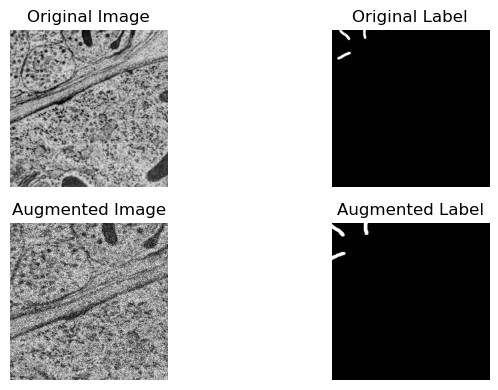

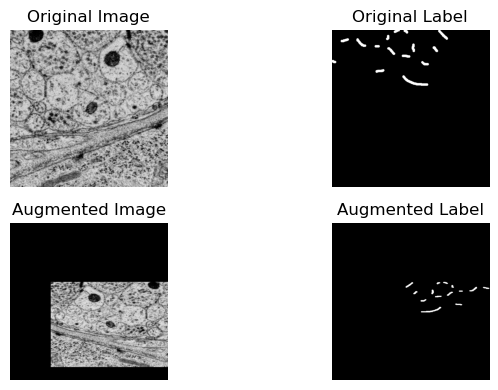

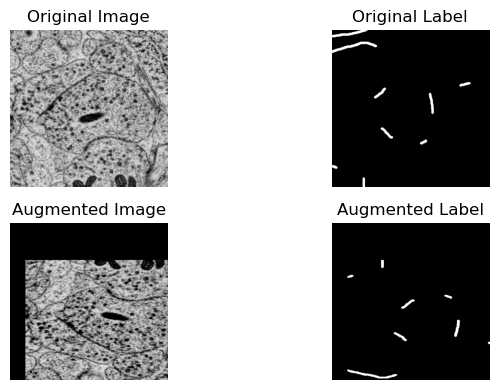

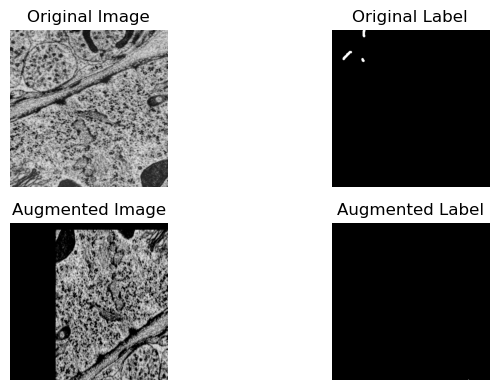

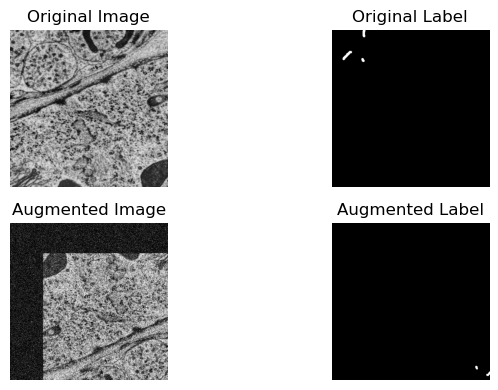

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

aug = get_custom_augmentation()

img_dir = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs"
label_dir = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts"
img_files = os.listdir(img_dir)

for i in range(5):
    img_name = np.random.choice(img_files)
    img_path = os.path.join(img_dir, img_name)
    # Build label filename
    base, ext = os.path.splitext(img_name)
    label_name = f"{base}_label{ext}"
    label_path = os.path.join(label_dir, label_name)

    # Read image and label
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (512, 512))
    label = cv2.resize(label, (512, 512))

    # Albumentations expects HWC, so expand dims for grayscale
    image = np.expand_dims(image, axis=-1)
    label = np.expand_dims(label, axis=-1)

    # Apply augmentation (pass label as 'mask')
    augmented = aug(image=image, mask=label)
    aug_img = augmented['image'].squeeze().cpu().numpy()
    aug_label = augmented['mask'].squeeze().cpu().numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Original Label")
    plt.imshow(label.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Augmented Image")
    plt.imshow(aug_img, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Augmented Label")
    plt.imshow(aug_label, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [32]:
print(img_path)
print(label_path)

/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs/SEM_adult_image_export_s258_part4.png
/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts/SEM_adult_image_export_s258_part4_label.png


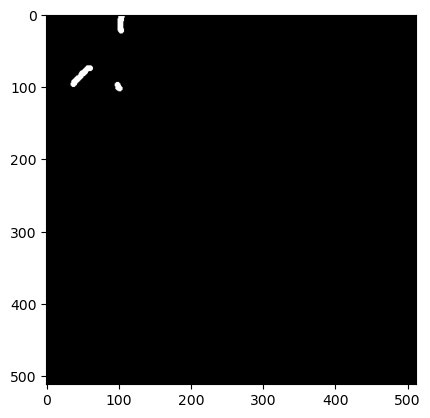

In [33]:
import random
import matplotlib.pyplot as plt
path = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts"
image = os.path.join(path, random.choice(os.listdir(path)))
image = cv2.imread("/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts/SEM_adult_image_export_s258_part4_label.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')